# **1) EXPLORATIVE DATA ANALYSIS**

---


In [ ]:
%%capture
!pip install -U spaCy
!python -m spacy download it_core_news_lg
!pip install transformers
!pip install datasets
!pip install evaluate

In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import string
import re
import requests
import random
import os

# Graphics Libs
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 18, 8
import matplotlib.colors as mcolors
from wordcloud import WordCloud

# Pre-processing
import spacy
import nltk
import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
nltk.download('stopwords')
from nltk.corpus import stopwords

# Gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models.tfidfmodel import TfidfModel
from gensim.corpora import Dictionary
from multiprocessing import cpu_count

# Models and utils
from sklearn.preprocessing import MinMaxScaler
from tqdm.auto import tqdm
import evaluate
from sklearn.metrics import accuracy_score, classification_report, precision_score, f1_score, recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Pytorch library for neural network
import torch
from torch import nn, optim
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print('Device is: ', str(device).upper())
from torch.utils.data import DataLoader

# HugginFace Utils
from datasets import load_dataset, DatasetDict, Dataset
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import BertTokenizer, BertModel

Device is:  MPS


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/albertogvalerio/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
BASE_PATHS = [
    # Base paths for training
    'https://cdn.albertovalerio.com/datasets/dankmemes/dankmemes_task_1/',
    'https://cdn.albertovalerio.com/datasets/dankmemes/dankmemes_task_2/',
    'https://cdn.albertovalerio.com/datasets/dankmemes/dankmemes_task_3/',

    # Base paths for testing
    'https://cdn.albertovalerio.com/datasets/dankmemes/1_test/',
    'https://cdn.albertovalerio.com/datasets/dankmemes/2_test/',
    'https://cdn.albertovalerio.com/datasets/dankmemes/3_test/'
]

FILENAMES = [
    # Files for training
    'dankmemes_task1_train.csv',
    'dankmemes_task2_train.csv',
    'dankmemes_task3_train.csv',
    'dankmemes_task1_train_embeddings.csv',
    'dankmemes_task2_train_embeddings.csv',
    'dankmemes_task3_train_embeddings.csv',

    # Files for testing
    'meme_test_final.csv',
    'hate_test_final.csv',
    'event_test_final.csv',
    '1_test_embeddings.csv',
    '2_test_embeddings.csv',
    '3_test_embeddings_fixed.csv',

    # Utils
    'italian-swear-words-list_comma-separated-text-file.txt',
    'haspeede2_reference_taskAB-tweets.csv',

    # Testing task 2 with labels
    'hate_test_gold_standards.csv'
]

SAVED_MODELS = [
    # Trained on Dankmemes
    'https://cdn.albertovalerio.com/datasets/dankmemes/saved_models/bert_ita/',
    'https://cdn.albertovalerio.com/datasets/dankmemes/saved_models/umberto/',
    'https://cdn.albertovalerio.com/datasets/dankmemes/saved_models/feel_it/',
    'https://cdn.albertovalerio.com/datasets/dankmemes/saved_models/roberta/',

    # Trained on Dankmemes + HaSpeeDe
    'https://cdn.albertovalerio.com/datasets/dankmemes/saved_models/bert_ita_plus/',
    'https://cdn.albertovalerio.com/datasets/dankmemes/saved_models/umberto_plus/',
    'https://cdn.albertovalerio.com/datasets/dankmemes/saved_models/feel_it_plus/',
    'https://cdn.albertovalerio.com/datasets/dankmemes/saved_models/roberta_plus/'
]

In [4]:
task_1_train = pd.read_csv(BASE_PATHS[0] + FILENAMES[0])
task_2_train = pd.read_csv(BASE_PATHS[1] + FILENAMES[1])
task_3_train = pd.read_csv(BASE_PATHS[2] + FILENAMES[2])

task_1_test = pd.read_csv(BASE_PATHS[3] + FILENAMES[6])
task_2_test = pd.read_csv(BASE_PATHS[4] + FILENAMES[7])
task_3_test = pd.read_csv(BASE_PATHS[5] + FILENAMES[8])

task_2_standard = pd.read_csv(BASE_PATHS[4] + FILENAMES[14])

In [5]:
task_1_train.head()

,File,Engagement,Date,Manipulation,Visual,Text,Meme
0,0.jpg,11,2019-08-12,1,Salvini,satira cruda votaci.. saremo di parola il part...,1
1,1.jpg,2261,2019-08-21,0,0,"peccato per le accise, dai. c'eravamo quasi.",0
2,2.jpg,1327,2019-08-23,0,"Salvini, Di Maio","""che c'è ancora?"" ""aspetto un bambino""",1
3,3.jpg,18,2019-08-27,0,0,ora in onda speciale gr1 ascolta la diretta se...,0
4,4.jpg,617,2019-08-25,0,"Salvini, Di Maio",sta sciocchezza che sto pe fa e solo colpa tua,1


In [6]:
task_2_train.head()

,File,Engagement,Manipulation,Visual,Text,Hate Speech
0,1000.jpg,381,0,0,quando ti chiedono se sia peggiore fratelli d'...,1
1,1001.jpg,142,1,0,conte entra in un negozio di telefonia e passa...,0
2,1002.jpg,3598,1,"Di Maio, Zingaretti, Berlusconi, Salvini",i politicanti italici non vedono l'ora di anda...,1
3,1003.jpg,165,1,"Salvini, Renzi",sono scemo. io di più. scemo & più scemo,1
4,1004.jpg,44,0,0,"beppe grillo (2017) genova, 21 luglio 1948 pol...",0


In [7]:
task_3_train.head()

,File,Engagement,Date,Macro,Manipulation,Visual,Text,Event
0,2000.jpg,994,2019-05-09,0,1,Lega,suca salvini rosica,0
1,2001.jpg,20,2019-08-29,0,0,0,"in nome del popolo italiano, i cittadini itali...",0
2,2002.jpg,15,2016-07-08,0,0,0,"vladimir, ti interessa l'affare immigrati? asc...",0
3,2003.jpg,9,2019-08-29,0,0,"Meloni, Mattarella","""ma come chi sono? presidè sò io senza fotosci...",2
4,2004.jpg,12,2019-01-31,0,0,0,"cos'era? un topo di fogna? ah...no, salvini.",0


In [8]:
task_2_standard.head()

,File,Engagement,Manipulation,Visual,Text,Hate Speech
0,5000.jpg,41,0,0,ogni singolo pensiero di salvini,1
1,5001.jpg,7,1,Salvini,per un nuovo governo: facile.it governare è fa...,0
2,5002.jpg,22,0,Lega,la lega a roma? e poi sarei io er monnezza! er...,1
3,5003.jpg,137,1,Conte,internazionale può funzionare un'alleanza tra ...,0
4,5004.jpg,2667,0,PD,esempi di cose che si autodistruggono,1


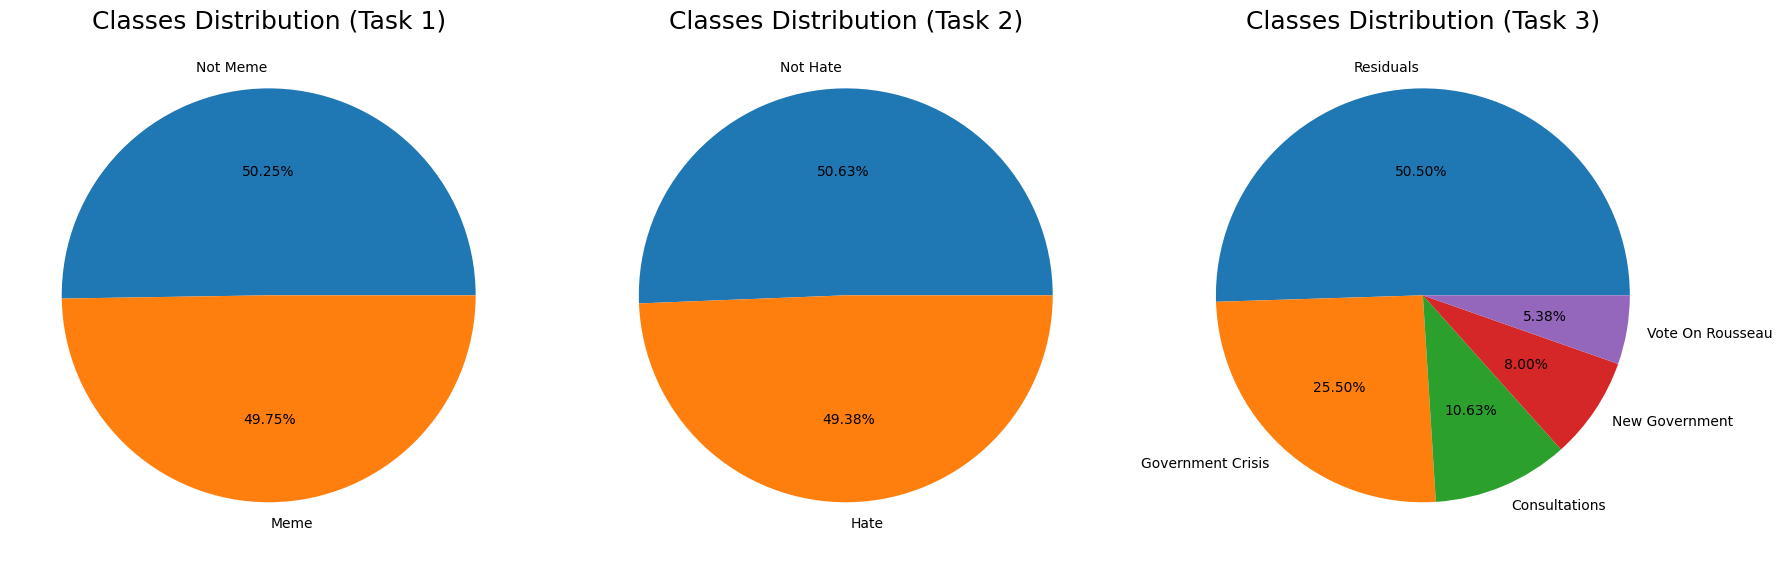

In [9]:
count1 = task_1_train['Meme'].value_counts()
count2 = task_2_train['Hate Speech'].value_counts()
count3 = task_3_train['Event'].value_counts()

labels1 = ['Not Meme', 'Meme']
labels2 = ['Not Hate', 'Hate']
labels3 = ['Residuals', 'Government Crisis', 'Consultations', 'New Government', 'Vote On Rousseau']

fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(18, 6))
ax1.pie(count1, labels=labels1, autopct = '%1.2f%%')
ax2.pie(count2, labels=labels2, autopct = '%1.2f%%')
ax3.pie(count3, labels=labels3, autopct = '%1.2f%%')
ax1.set_title('Classes Distribution (Task 1)', fontsize = 18)
ax2.set_title('Classes Distribution (Task 2)', fontsize = 18)
ax3.set_title('Classes Distribution (Task 3)', fontsize = 18)

plt.tight_layout()
plt.show()

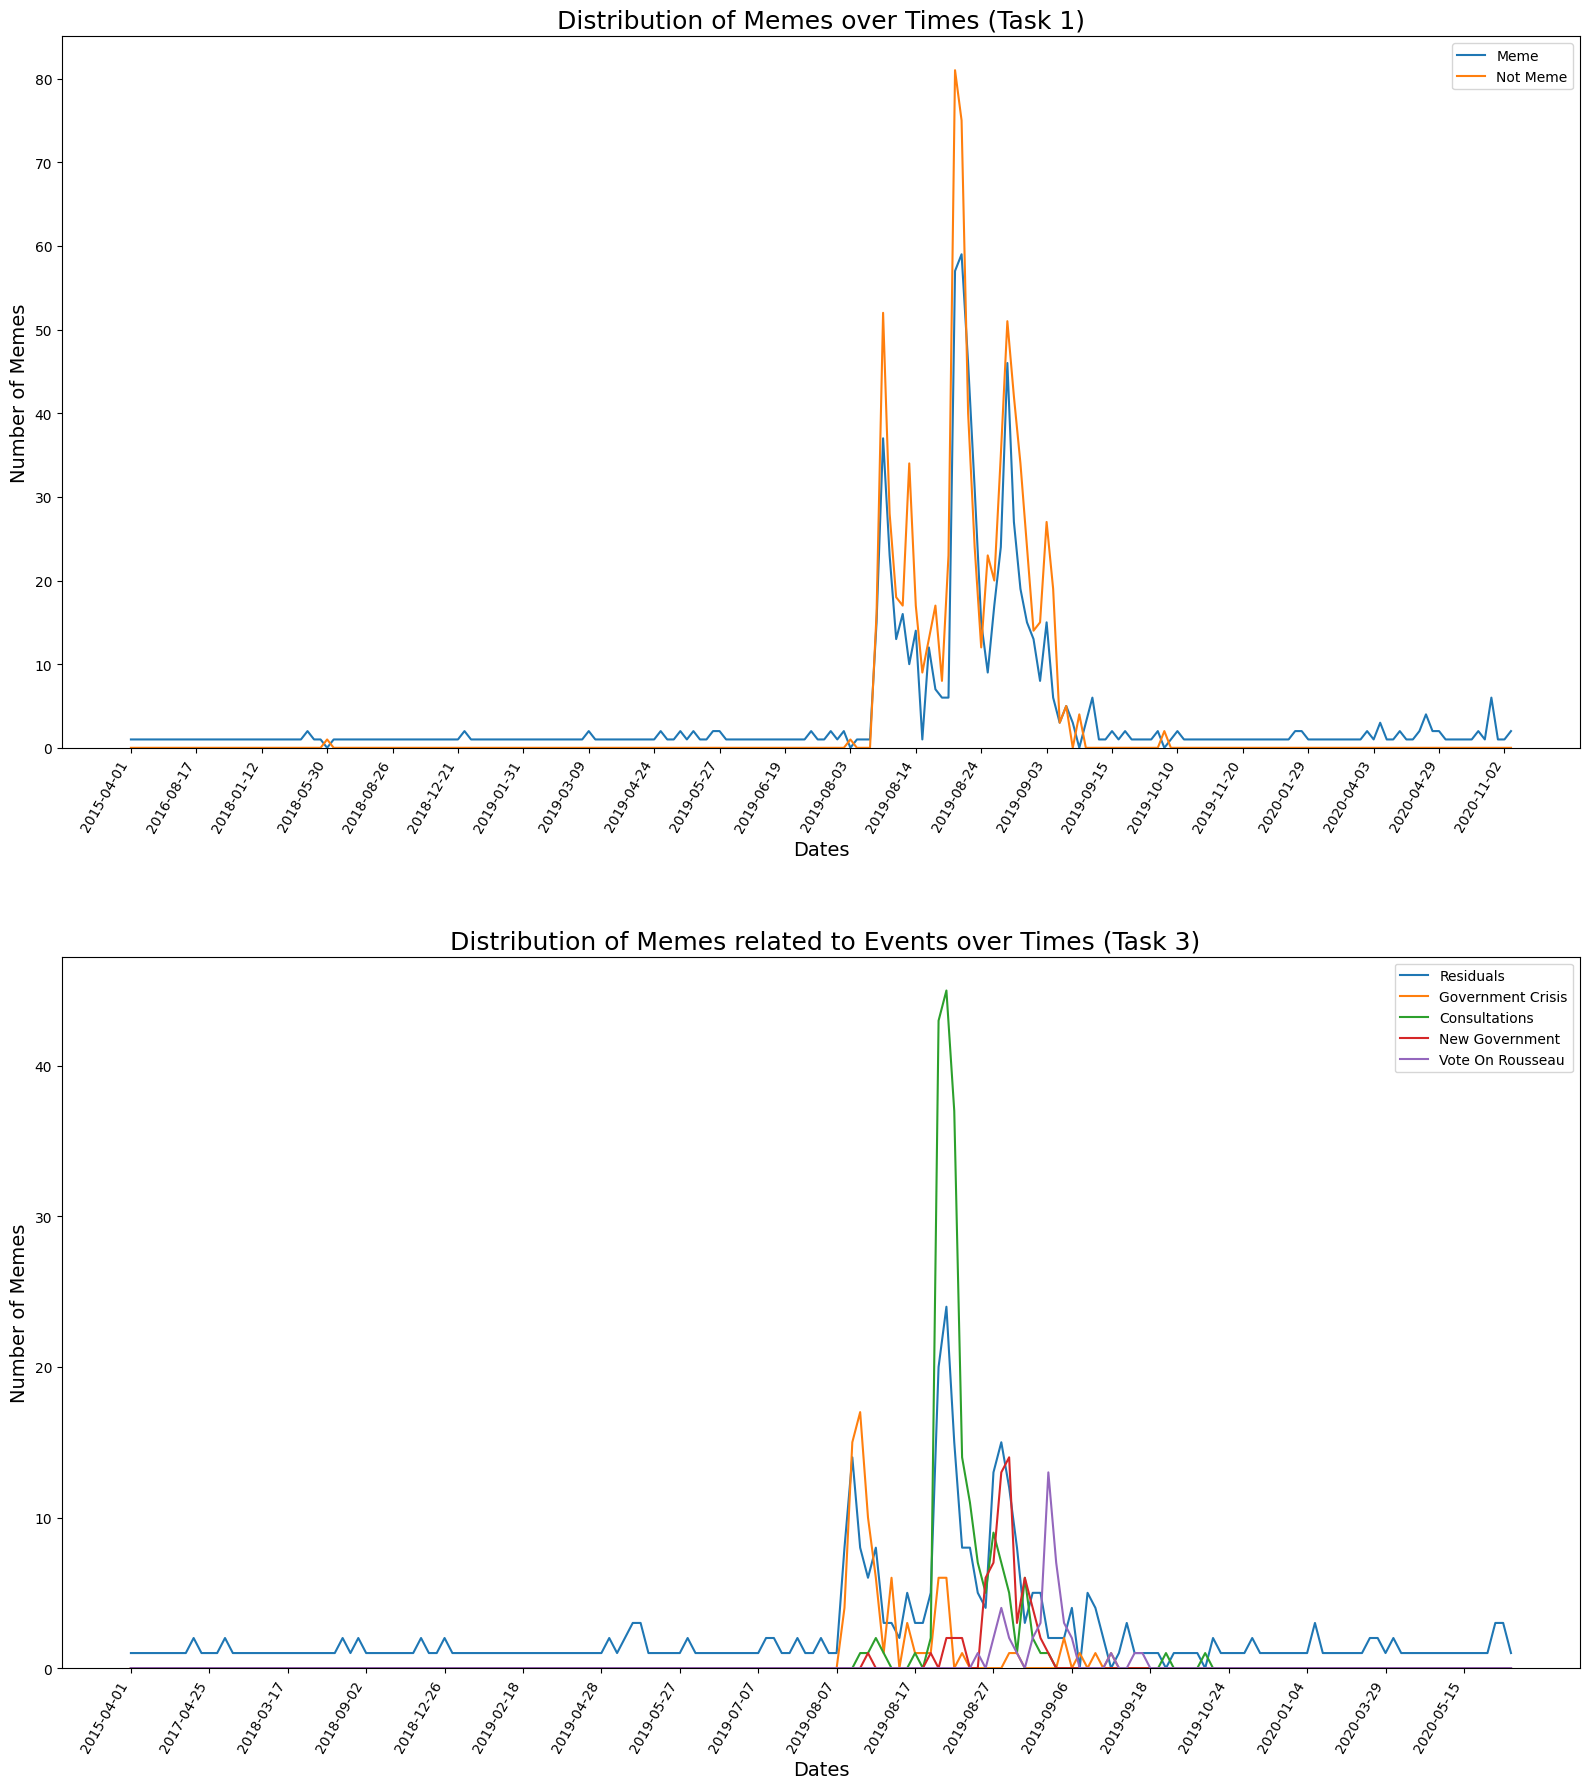

In [10]:
not_memes_by_date = task_1_train[task_1_train['Meme'] == 0].groupby('Date').size()
memes_by_date = task_1_train[task_1_train['Meme'] == 1].groupby('Date').size()
df1 = pd.DataFrame(index=pd.concat([not_memes_by_date, memes_by_date], axis=1).index, columns=['Meme','Not Meme'])
df1.loc[not_memes_by_date.index, 'Not Meme'] = not_memes_by_date.values
df1.loc[memes_by_date.index, 'Meme'] = memes_by_date.values
df1 = df1.sort_index()
df1 = df1.fillna(0)

class_0_by_date = task_3_train[task_3_train['Event'] == 0].groupby('Date').size()
class_1_by_date = task_3_train[task_3_train['Event'] == 1].groupby('Date').size()
class_2_by_date = task_3_train[task_3_train['Event'] == 2].groupby('Date').size()
class_3_by_date = task_3_train[task_3_train['Event'] == 3].groupby('Date').size()
class_4_by_date = task_3_train[task_3_train['Event'] == 4].groupby('Date').size()
df2 = pd.DataFrame(index=pd.concat([class_0_by_date, class_1_by_date, class_2_by_date, class_3_by_date, class_4_by_date], axis=1).index,
                   columns=['Residuals', 'Government Crisis', 'Consultations', 'New Government', 'Vote On Rousseau'])
df2.loc[class_0_by_date.index, 'Residuals'] = class_0_by_date.values
df2.loc[class_1_by_date.index, 'Government Crisis'] = class_1_by_date.values
df2.loc[class_2_by_date.index, 'Consultations'] = class_2_by_date.values
df2.loc[class_3_by_date.index, 'New Government'] = class_3_by_date.values
df2.loc[class_4_by_date.index, 'Vote On Rousseau'] = class_4_by_date.values
df2 = df2.sort_index()
df2 = df2.fillna(0)


fig, ((ax1), (ax2)) = plt.subplots(2, 1, figsize=(16, 18))
ax1.plot(df1.index, df1['Meme'], label='Meme')
ax1.plot(df1.index, df1['Not Meme'], label='Not Meme')
ax1.set_xlabel('Dates', fontsize = 14)
ax1.set_ylabel('Number of Memes', fontsize = 14)
ax1.set_xticks([df1.index[i] for i in range(0,len(df1.index),10)])
ax1.set_xticklabels([df1.index[i] for i in range(0,len(df1.index),10)], rotation = 60, ha="right")
ax1.set_ylim(ymin=0)
ax1.legend(loc='upper right')
ax1.set_title('Distribution of Memes over Times (Task 1)', fontsize = 18)
ax2.plot(df2.index, df2['Residuals'], label='Residuals')
ax2.plot(df2.index, df2['Government Crisis'], label='Government Crisis')
ax2.plot(df2.index, df2['Consultations'], label='Consultations')
ax2.plot(df2.index, df2['New Government'], label='New Government')
ax2.plot(df2.index, df2['Vote On Rousseau'], label='Vote On Rousseau')
ax2.set_xlabel('Dates', fontsize = 14)
ax2.set_ylabel('Number of Memes', fontsize = 14)
ax2.set_xticks([df2.index[i] for i in range(0,len(df2.index),10)])
ax2.set_xticklabels([df2.index[i] for i in range(0,len(df2.index),10)], rotation = 60, ha="right")
ax2.set_ylim(ymin=0)
ax2.legend(loc='upper right')
ax2.set_title('\n\n Distribution of Memes related to Events over Times (Task 3)', fontsize = 18)

plt.tight_layout()
plt.show()

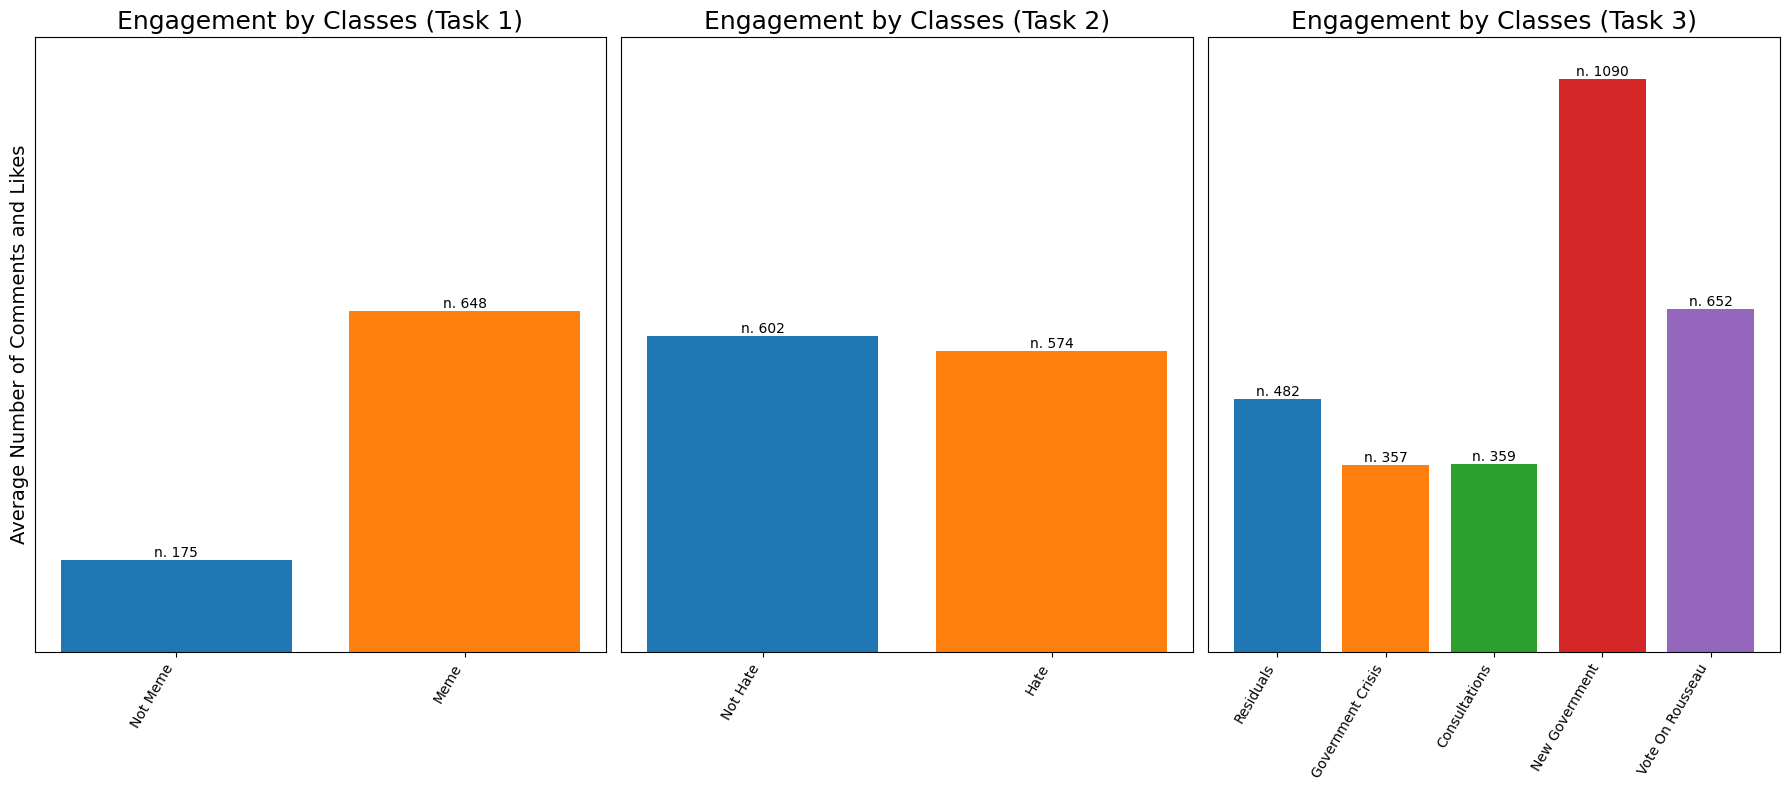

In [11]:
height1 = [
    task_1_train[task_1_train['Meme'] == 0]['Engagement'].mean(),
    task_1_train[task_1_train['Meme'] == 1]['Engagement'].mean()
]
height2 = [
    task_2_train[task_2_train['Hate Speech'] == 0]['Engagement'].mean(),
    task_2_train[task_2_train['Hate Speech'] == 1]['Engagement'].mean()
]
height3 = [
    task_3_train[task_3_train['Event'] == 0]['Engagement'].mean(),
    task_3_train[task_3_train['Event'] == 1]['Engagement'].mean(),
    task_3_train[task_3_train['Event'] == 2]['Engagement'].mean(),
    task_3_train[task_3_train['Event'] == 3]['Engagement'].mean(),
    task_3_train[task_3_train['Event'] == 4]['Engagement'].mean(),
]

fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(18, 8))
colors = mcolors.TABLEAU_COLORS
bars1 = ax1.bar(labels1, height=height1, color=colors)
ax1.set_ylabel('Average Number of Comments and Likes', fontsize = 14)
for rect in bars1:
     height = rect.get_height()
     ax1.text(rect.get_x() + rect.get_width() / 2.0, height, f'n. {height:.0f}', ha='center', va='bottom')
bars2 = ax2.bar(labels2, height=height2, color=colors)
for rect in bars2:
     height = rect.get_height()
     ax2.text(rect.get_x() + rect.get_width() / 2.0, height, f'n. {height:.0f}', ha='center', va='bottom')
bars3 = ax3.bar(labels3, height=height3, color=colors)
for rect in bars3:
     height = rect.get_height()
     ax3.text(rect.get_x() + rect.get_width() / 2.0, height, f'n. {height:.0f}', ha='center', va='bottom')

ax1.set_yticks([])
ax2.set_yticks([])
ax3.set_yticks([])
ax1.set_title('Engagement by Classes (Task 1)', fontsize = 18)
ax2.set_title('Engagement by Classes (Task 2)', fontsize = 18)
ax3.set_title('Engagement by Classes (Task 3)', fontsize = 18)
ax1.set_ylim(ymin=0, ymax=(max(height3)+80))
ax2.set_ylim(ymin=0, ymax=(max(height3)+80))
ax3.set_ylim(ymin=0, ymax=(max(height3)+80))
ax1.set_xticklabels(labels1, rotation = 60, ha="right")
ax2.set_xticklabels(labels2, rotation = 60, ha="right")
ax3.set_xticklabels(labels3, rotation = 60, ha="right")
plt.tight_layout()
plt.show()

# **2) PRE-PROCESSING**

---


In [12]:
punctuations = string.punctuation
nlp = spacy.load("it_core_news_lg")
stop_words = stopwords.words('italian')

r = requests.get(BASE_PATHS[1] + FILENAMES[12])
swear_words = r.content.decode()

In [13]:
# This function convert a user censored bad word (i.e. "sei una m***a")
# with an equivalent one taken from a list of italian bad words
# according to the same initial and final uncesored letters and to the same POS tag (where possible!)
def get_explicit(censored):
    explicit = ''
    start = censored.split('*')[0] if '*' in censored else censored.split('x')[0]
    end = censored.split('*')[-1] if '*' in censored else censored.split('x')[-1]
    pattern = '\\b, '+start+'[a-z]*'+end+'\\b'
    all = ' '.join([w[2:] for w in re.findall(pattern, swear_words)])
    if all:
        options = [o for o in nlp(all)]
        options_tag_check = [o for o in nlp(all) if o.tag_ is nlp(censored)[0].tag_]
        if len(options_tag_check):
            explicit = random.choice(options_tag_check).text
        else:
            explicit = random.choice(options).text
    return explicit

In [14]:
def my_preprocessing(sentence, hashtag=False, explicit=True, lemmatization=True):

    #1 Normalization
    if hashtag:
        sentence = ' '.join(re.sub("@\w+|#\w+", "", sentence).split())

    if explicit:
        matches = re.findall('\w+\*+\w+|\w+x+\w+', sentence)
        for m in matches:
            sentence = sentence.replace(m, get_explicit(m))

    #2 Tokenization
    tokens = nlp(sentence)

    #3 Cleaning (removing punctuation and stop words)
    tokens = [ word.text for word in tokens ]
    tokens = [ word for word in tokens if word not in stop_words and word not in punctuations and "." not in word and "'" not in word ]
    tokens = [ word for word in tokens if len(word) > 2]

    #4 Lemmatization
    if lemmatization:
        tokens = [w.lemma_.lower() for w in nlp(' '.join(tokens))]

    return tokens

In [15]:
for i in task_2_train.sample(n=10)['Text']:
    print(f'{"ORIGINAL:":<20}{i}')
    print(f'{"PROCESSED:":<20}{my_preprocessing(i)}')
    print(f'{"NO_LEMMATIZATION:":<20}{my_preprocessing(i, lemmatization=False)}')
    print('\n')

ORIGINAL:           problems stress pain io maratona mentana
PROCESSED:          ['problems', 'stress', 'pain', 'maratona', 'mentano']
NO_LEMMATIZATION:   ['problems', 'stress', 'pain', 'maratona', 'mentana']


ORIGINAL:           quando perdiamo il diritto di essere diversi perdiamo il privilegio di essere liberi. ovvero... lega merda
PROCESSED:          ['quando', 'perdare', 'diritto', 'essere', 'diverso', 'perdere', 'privilegio', 'essere', 'libero', 'ovvero', 'legare', 'merda']
NO_LEMMATIZATION:   ['quando', 'perdiamo', 'diritto', 'essere', 'diversi', 'perdiamo', 'privilegio', 'essere', 'liberi', 'ovvero', 'lega', 'merda']


ORIGINAL:           santanché soddisfatta che la sfiducia a conte sia in agenda il 20 agosto, avendo prenotato il giorno prima dal parrucchiere.
PROCESSED:          ['santanché', 'soddisfatto', 'sfiducia', 'conte', 'agenda', 'agosto', 'prenotare', 'giorno', 'prima', 'parrucchiere']
NO_LEMMATIZATION:   ['santanché', 'soddisfatta', 'sfiducia', 'conte', 'agenda', '

# **3) FEATURES EXTRACTION**

---


In [16]:
data = task_2_train

## **Tokens**

In [17]:
data['Tokens'] = data['Text'].apply(lambda x:' '.join(my_preprocessing(x)))
data = data[['File', 'Engagement', 'Manipulation', 'Visual', 'Text', 'Tokens', 'Hate Speech']]
data.sample(n=10)

,File,Engagement,Manipulation,Visual,Text,Tokens,Hate Speech
377,1377.jpg,10,0,0,sagre e selfie figure di merda felpe bacioni n...,sagra selfie figura merda felpa bacione nutell...,1
93,1093.jpg,456,1,0,1 sergio mattarella 2 sergio mattarella 3 serg...,sergio mattarella sergio mattarella sergio mat...,0
727,1727.jpg,19,0,"Conte, Mattarella",e vvinisti a mani vacanti? ti purtai na spasa ...,vvinisti mano vacante purtao spasa bbocconcini...,0
116,1116.jpg,12,0,"Mattarella, Berlusconi, Bernini, Gelmini, Tajani","...e poi gli ho detto: ""mattè, finché c'è figa...",poi dire mattè finché figo speranza sereno,1
433,1433.jpg,302,0,"Salvini, Mattarella",basta governi non eletti dal popolo. gli itali...,bastare governo eletto popolo italiano volere ...,0
758,1758.jpg,41,1,"Salvini, Di Maio","matteo salvini, gli sms con di maio: io sono p...",matteo salvini sms maio pronto ricostruire rap...,1
505,1505.jpg,26,0,Di Maio,quando l'italia crede che ti sia tirato indiet...,quando italia credere tirare indietro bene naz...,1
118,1118.jpg,2978,0,Mattarella,ma porco di,porco,1
36,1036.jpg,97,0,"Grillo, Di Maio","""però 'n po' me manca"" ""ma sai quanti ne trovi...",però mancare sai trovare mejo,0
722,1722.jpg,141,0,Salvini,la tua ignoranza è il mio stipendio,ignoranza stipendio,1


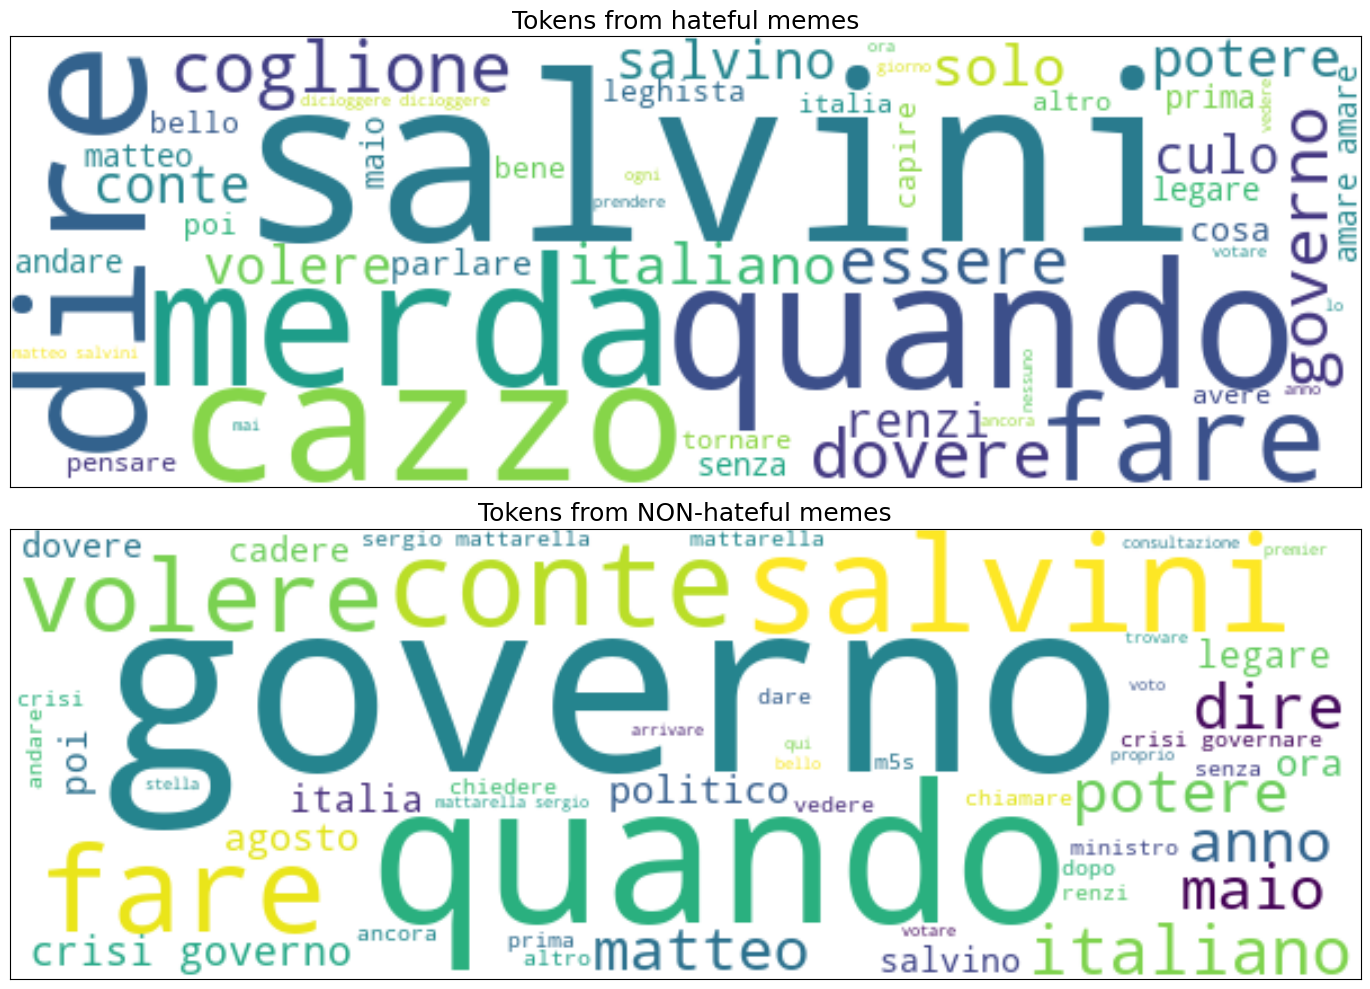

In [18]:
hateful_meme_tokens = data[data['Hate Speech']==1]['Tokens'].tolist()
nonhateful_meme_tokens = data[data['Hate Speech']==0]['Tokens'].tolist()
wordcloud_hate = WordCloud(max_words=50, width=600, background_color='white').generate(" ".join(hateful_meme_tokens))
wordcloud_not_hate = WordCloud(max_words=50, width=600, background_color='white').generate(" ".join(nonhateful_meme_tokens))

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 10))
ax1.imshow(wordcloud_hate, interpolation='bilinear')
ax2.imshow(wordcloud_not_hate, interpolation='bilinear')
ax1.set_title('Tokens from hateful memes', fontsize = 18)
ax2.set_title('Tokens from NON-hateful memes', fontsize = 18)
ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])

plt.tight_layout()
plt.show()

## **Hate Score**

The hate score is given by the difference between the number of hate meme and the number of not hate meme for each of the people in 'Visual' column.

In [19]:
visuals = task_2_train['Visual']
people = []
for i in visuals:
    s = i.split(',')
    s = [j.strip() for j in s if j != ' ' and j != '']
    for e in s:
        if (e is not '0' and e.title() not in people):
            people.append(e.title())

df3 = pd.DataFrame(index=[p.title() for p in people], columns=['Hate Meme','Not Hate Meme','Hate Score'])
for p in people:
    all_by_person = task_2_train[task_2_train['Visual'].str.contains(p, case=False)]
    df3.loc[p, 'Hate Meme'] = 0-len(all_by_person[task_2_train['Hate Speech'] == 1])
    df3.loc[p, 'Not Hate Meme'] = len(all_by_person[task_2_train['Hate Speech'] == 0])
    df3.loc[p, 'Hate Score'] = len(all_by_person[task_2_train['Hate Speech'] == 0]) - len(all_by_person[task_2_train['Hate Speech'] == 1])

df3 = df3.sort_values('Hate Score')
df3.sample(n=10)

,Hate Meme,Not Hate Meme,Hate Score
Giannino,-1,0,-1
Di Maio,-42,71,29
Gentiloni,-2,1,-1
Di Battista,0,1,1
Civati,-1,1,0
Draghi,0,1,1
Giovanardi,-1,0,-1
Casalino,-3,1,-2
Bernini,-1,1,0
Toninelli,-2,0,-2


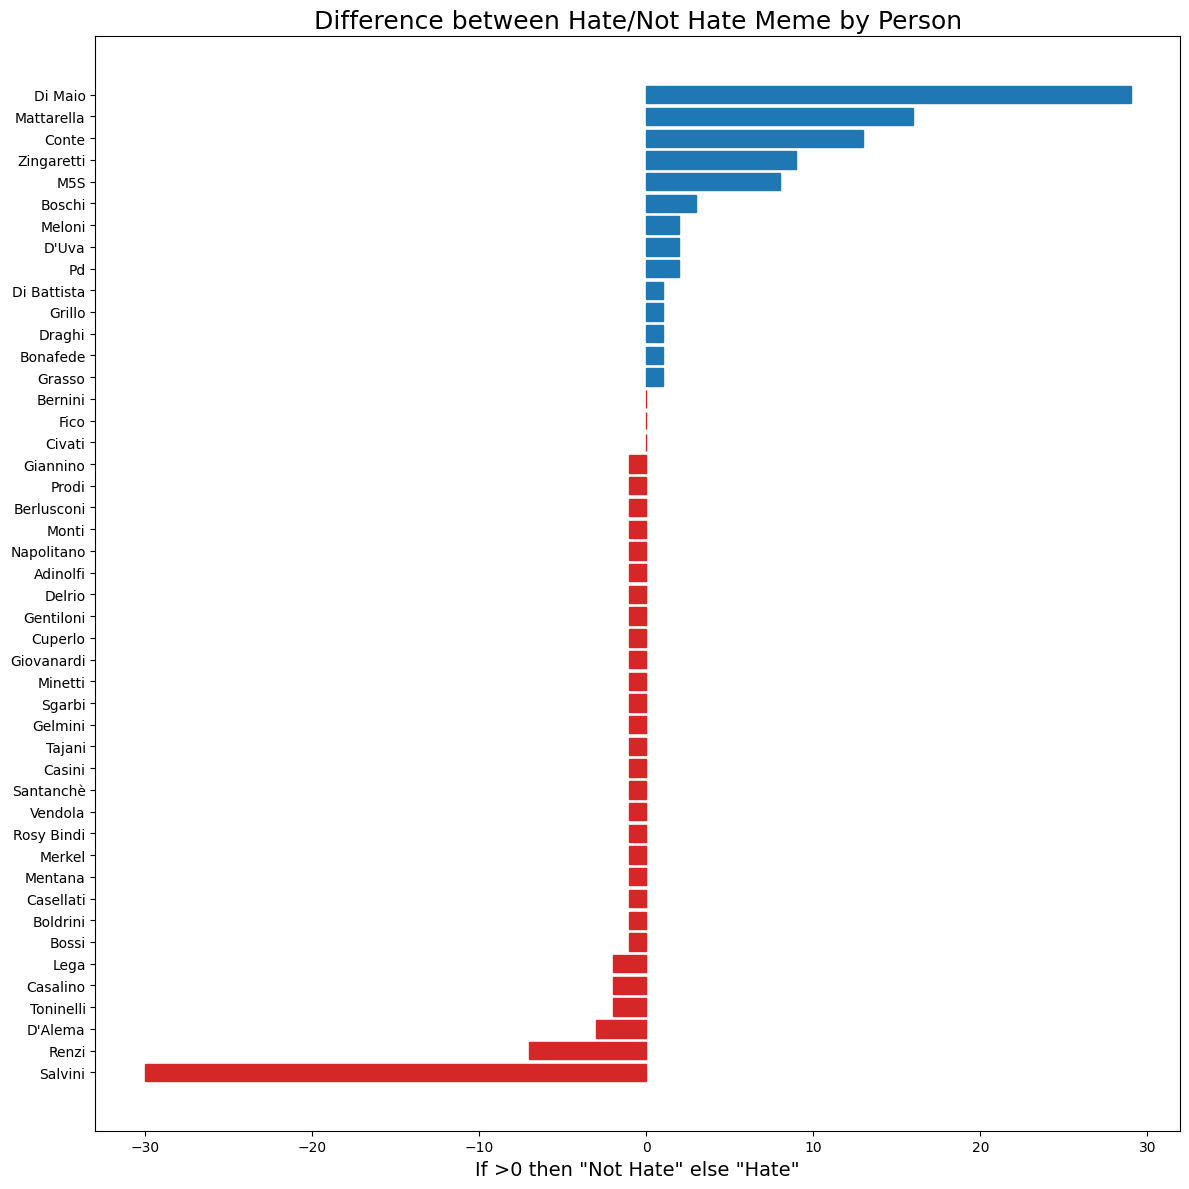

In [20]:
fig, ax1 = plt.subplots(1, 1, figsize=(12, 12))
colors = mcolors.TABLEAU_COLORS
bars1 = ax1.barh(df3.index, width=df3['Hate Score'], color=colors)
ax1.set_xlabel('If >0 then "Not Hate" else "Hate"', fontsize = 14)
for rect in bars1:
    width = rect.get_width()
    if (width > 0):
        rect.set_color('tab:blue')
    else:
        rect.set_color('tab:red')

ax1.set_title('Difference between Hate/Not Hate Meme by Person', fontsize = 18)
plt.tight_layout()
plt.show()

In [21]:
# The hate score is given by the difference between the number of
# hate meme and the number of not hate meme for each of the people in 'Visual' column
def get_hate_score(visual, score_df):
    score = np.NAN
    if (visual != '0'):
        visual = visual.split(',')
        visual = [j.strip().title() for j in visual if j != ' ' and j != '' and j != '0']
        visual = [j for j in visual if j in score_df.index]
        score = score_df.loc[visual, 'Hate Score'].sum()
    return score

data['Hate Score'] = data['Visual'].apply(lambda x:get_hate_score(x, df3))
data = data[['File', 'Engagement', 'Manipulation', 'Visual', 'Hate Score', 'Text', 'Tokens', 'Hate Speech']]
data.sample(n=10)

,File,Engagement,Manipulation,Visual,Hate Score,Text,Tokens,Hate Speech
136,1136.jpg,36,0,0,NaN,conte: docente universitario conte: durante il...,conte docente universitario conte durante gove...,0
226,1226.jpg,92,1,"Conte, Di Maio",42.0,biiiiiissssssss!!!,biiiiiissssssss,0
522,1522.jpg,27,0,Salvini,-30.0,"potrebbe succedere anche a te, usa il preserva...",potere succedere usare preservativo,1
197,1197.jpg,91,1,Salvini,-30.0,dra-culo,dra culo,1
458,1458.jpg,72,1,"M5S, Lega, PD",8.0,32%+17%=49% rappresenta gli italiani! 32%+19%=...,32%+17%=49 rappresentare italiano 32%+19%=51 r...,0
214,1214.jpg,74,0,0,NaN,#salvinimerda #dejomerda,salvinimerda dejomerdo,1
672,1672.jpg,388,0,"Salvini, Mattarella",-14.0,"c'era il 3x2 sugli abiti uomo da oviesse, eh...?",abito uomo oviere,0
654,1654.jpg,46,0,"Conte, Salvini",-17.0,ma per caso sei gay? no perché? ti ho visto pa...,caso gay vedere parlare gay neanche ritardare ...,1
183,1183.jpg,188,0,"Meloni, Salvini",-28.0,"molti si fanno abbindolare, sia dalla meloni c...",molto abbindolare melone salvini cosa altro at...,0
270,1270.jpg,6915,0,Conte,13.0,"""ma ti prego, se non ti dispiace, per amore de...",pregare dispiacere amore povero vecchio papà t...,0


## **Number of Words**

The number of words calculated for the original 'Text' column's data.

In [22]:
data['Nr Words'] = data['Text'].apply(lambda x:len(str(x).split()))
data = data[['File', 'Engagement', 'Manipulation', 'Visual', 'Hate Score', 'Text', 'Tokens', 'Nr Words', 'Hate Speech']]
data.sample(n=10)

,File,Engagement,Manipulation,Visual,Hate Score,Text,Tokens,Nr Words,Hate Speech
772,1772.jpg,5,1,Salvini,-30.0,balla di lardo,ballare lardo,3,1
203,1203.jpg,23,0,"Grillo, Renzi",-6.0,vaffanculo day. vendoilculo day,vaffanculo day vendoilculo day,4,1
280,1280.jpg,5,1,Lega,-2.0,caga slavini strunzier,cagare slavino strunzier,3,1
231,1231.jpg,30,0,0,NaN,righeira lo stato sta finendo,righeira stato finere,5,0
82,1082.jpg,9,1,0,NaN,"ehi, blatta. perchè esci solo di notte? per no...",ehi blattare perché esci solo notte vedere,15,1
315,1315.jpg,247,0,Zingaretti,9.0,che màl e càp,màl càp,4,0
684,1684.jpg,13,0,0,NaN,inconsapevoli addormentati. cov-id 19/id 20. t...,inconsapevolo addormentare cov tracciare posti...,15,1
326,1326.jpg,57,1,Conte,13.0,la signora in rousseau,signore rousseau,4,0
201,1201.jpg,6,0,0,NaN,"buonasera, sono jean-jacques rousseau. con la ...",buonasera jean jacques rousseau voce mattarella,9,0
474,1474.jpg,1918,1,Giovanardi,-1.0,stai sulle mie palle quindi spostati,palla quindi spostare,6,1


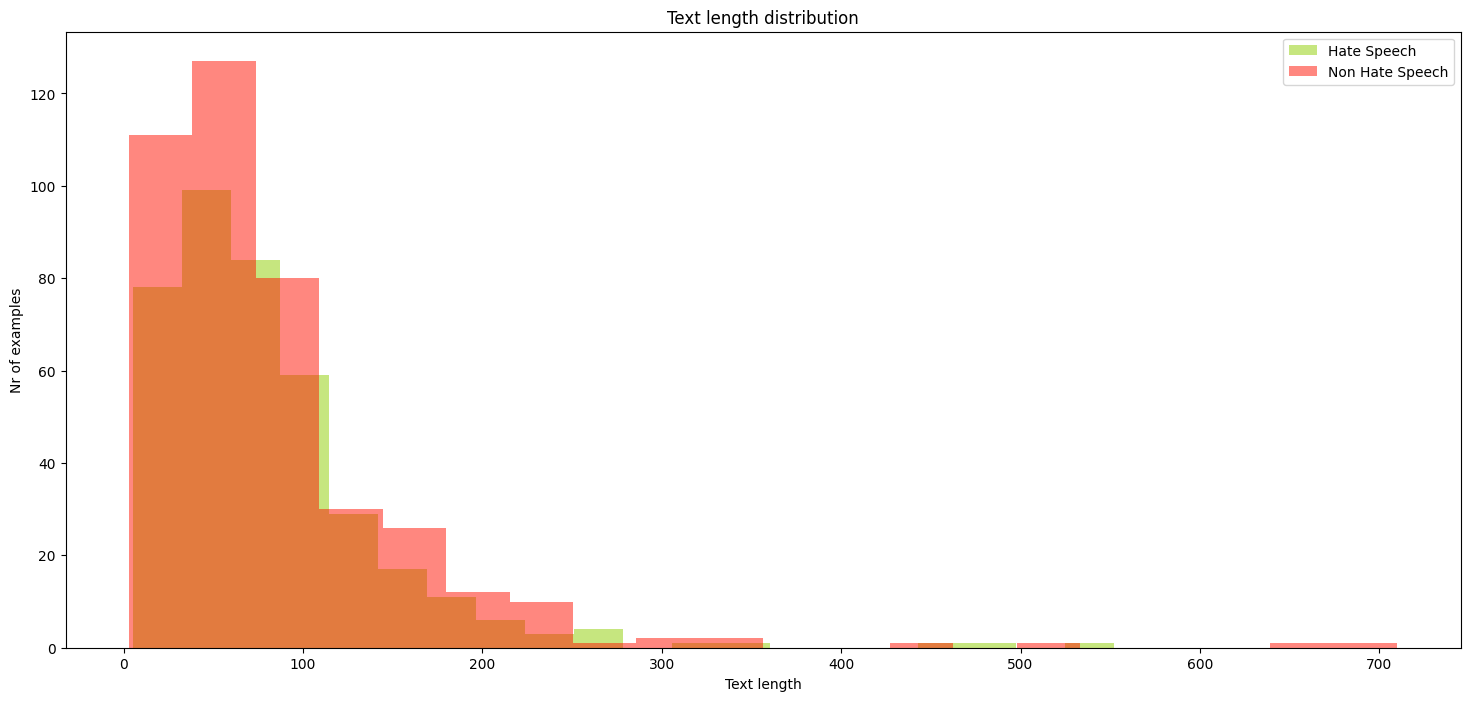

In [23]:
meme_dataset = data[data['Hate Speech'] == 1]
non_meme_dataset = data[data['Hate Speech'] == 0]
meme_dataset['Nr Words'] = meme_dataset['Text'].apply(len)
non_meme_dataset['Nr Words'] = non_meme_dataset['Text'].apply(len)
plt.hist(meme_dataset['Nr Words'], bins=20, alpha=0.5, label='Hate Speech', color='#8fce00')
plt.hist(non_meme_dataset['Nr Words'], bins=20, alpha=0.5, label='Non Hate Speech', color='#ff1100')
plt.xlabel('Text length')
plt.ylabel('Nr of examples')
plt.title('Text length distribution')
plt.legend()
plt.show()

## **Number of Tokens**

The number of words calculated for the 'Tokens' column's data.

In [24]:
data['Nr Tokens'] = data['Tokens'].apply(lambda x:len(str(x).split()))
data = data[['File', 'Engagement', 'Manipulation', 'Visual', 'Hate Score', 'Text', 'Tokens', 'Nr Words', 'Nr Tokens', 'Hate Speech']]
data.sample(n=10)

,File,Engagement,Manipulation,Visual,Hate Score,Text,Tokens,Nr Words,Nr Tokens,Hate Speech
762,1762.jpg,65,1,Mattarella,16.0,quando sei mattarella e ti dicono se vuioi tor...,quando mattarella dire vuioi tornare voto akun...,122,61,0
798,1798.jpg,452,0,"Boschi, Renzi",-4.0,renzi pronto a lanciare azione civile. ingroia...,renzi pronto lanciare azione civile ingroia si...,26,15,1
317,1317.jpg,39,1,Salvini,-30.0,"ew, i stepped in shit.",stepped shito,5,2,1
253,1253.jpg,19,1,Conte,13.0,dobby non ha padrony dobby è un elfo libero,dobby padrony dobby elfo libero,9,5,0
530,1530.jpg,43,0,0,NaN,elezioni,elezione,1,1,1
260,1260.jpg,66,0,0,NaN,non è il momento delle polemiche siamo in una ...,momento polemico emergenza salvini sfiducio cr...,21,9,1
104,1104.jpg,1834,0,Renzi,-7.0,piddinacci schifosi piddinacci ahahahahahah pi...,piddinaccio schifoso piddinaccio ahahahahahah ...,6,6,1
40,1040.jpg,91,1,Mattarella,16.0,"oh oh! non dirmelo, è caduto il governo vero? ...",dirmelo cadere governo vero già momento consul...,20,9,0
666,1666.jpg,18,0,Renzi,-7.0,"obama: da noi, un operario americano guadagna ...",obama operario americano guadagnare 3000 dolla...,94,50,1
506,1506.jpg,11,0,0,NaN,il governo giallo-verde cade* il giallo che ve...,governo giallo verde cadere giallo vedere rosso,10,7,0


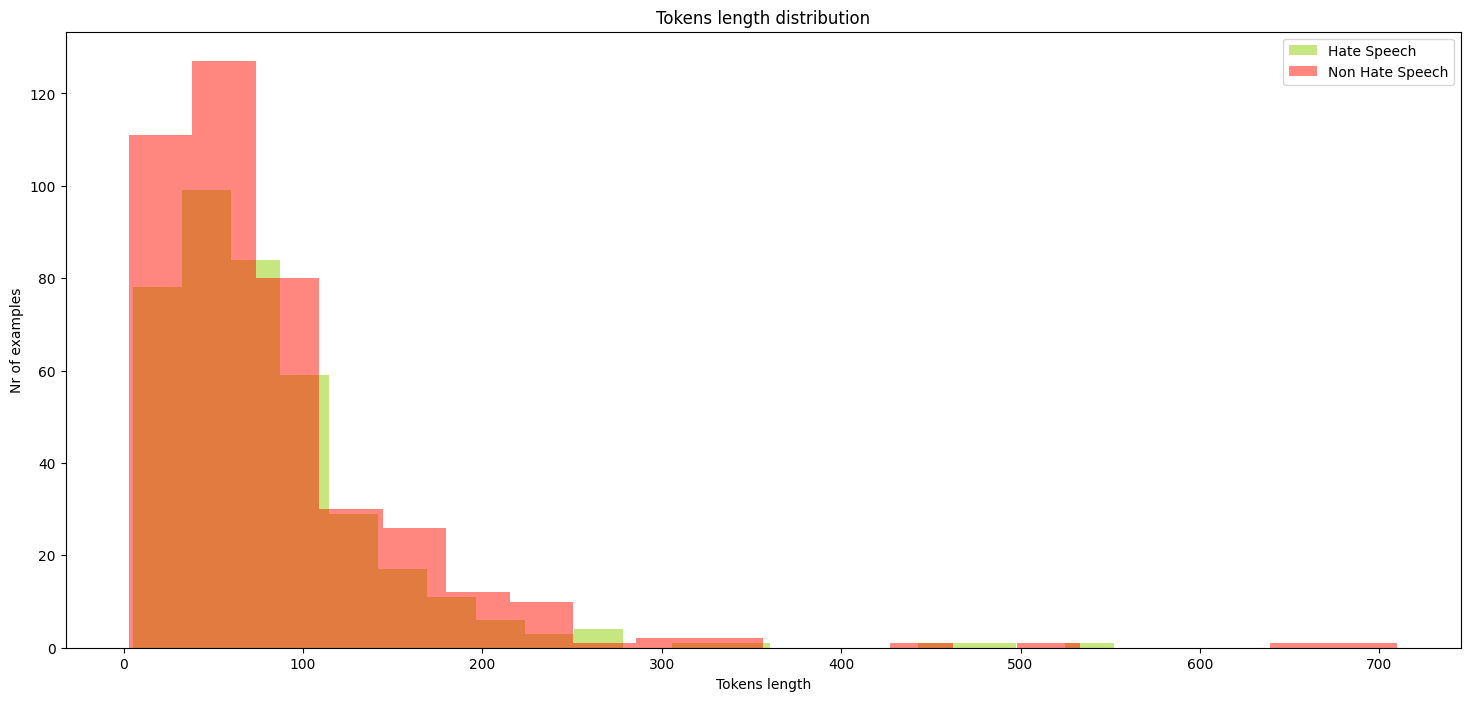

In [25]:
meme_dataset = data[data['Hate Speech'] == 1]
non_meme_dataset = data[data['Hate Speech'] == 0]
meme_dataset['Nr Tokens'] = meme_dataset['Text'].apply(len)
non_meme_dataset['Nr Tokens'] = non_meme_dataset['Text'].apply(len)
plt.hist(meme_dataset['Nr Tokens'], bins=20, alpha=0.5, label='Hate Speech', color='#8fce00')
plt.hist(non_meme_dataset['Nr Tokens'], bins=20, alpha=0.5, label='Non Hate Speech', color='#ff1100')
plt.xlabel('Tokens length')
plt.ylabel('Nr of examples')
plt.title('Tokens length distribution')
plt.legend()
plt.show()

## **Doc2vec**

Tokens embeddings.

In [26]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(data['Tokens'])]
d2v = Doc2Vec(vector_size=32, window=2, min_count=1)
d2v.build_vocab(documents)

In [27]:
data['Doc2Vec'] = data['Tokens'].apply(lambda x: d2v.infer_vector(x.split()))
data = data[['File', 'Engagement', 'Manipulation', 'Visual', 'Hate Score', 'Text', 'Tokens', 'Nr Words', 'Nr Tokens', 'Doc2Vec', 'Hate Speech']]
data.head()

,File,Engagement,Manipulation,Visual,Hate Score,Text,Tokens,Nr Words,Nr Tokens,Doc2Vec,Hate Speech
0,1000.jpg,381,0,0,NaN,quando ti chiedono se sia peggiore fratelli d'...,quando chiedere peggiore fratello italia legar...,15,8,"[0.0087652, -0.00029748492, 0.009427272, -0.00...",1
1,1001.jpg,142,1,0,NaN,conte entra in un negozio di telefonia e passa...,conte entrare negozio telefonia passare manten...,14,7,"[0.00413714, 0.0058871005, -0.011804589, 0.009...",0
2,1002.jpg,3598,1,"Di Maio, Zingaretti, Berlusconi, Salvini",7.0,i politicanti italici non vedono l'ora di anda...,politicante italico vedere ora andare urna acc...,17,10,"[0.013524123, -0.01245533, -0.010451493, -0.00...",1
3,1003.jpg,165,1,"Salvini, Renzi",-37.0,sono scemo. io di più. scemo & più scemo,scemo scemo scemapere,9,3,"[0.009461498, -0.0041026482, -0.0029133437, 0....",1
4,1004.jpg,44,0,0,NaN,"beppe grillo (2017) genova, 21 luglio 1948 pol...",beppe grillo 2017 genova luglio 1948 politico ...,26,21,"[0.006297866, 0.012467129, 0.0036246348, 0.001...",0


## **TfIdf**

Tokens embeddings.

In [28]:
# Text tokenization
documents_tfidf = [text.split() for text in data['Text']]

# Creating dictionary
dictionary = Dictionary(documents_tfidf)

# Creating corpus
corpus_tfidf = [dictionary.doc2bow(doc) for doc in documents_tfidf]

# TF-IDF representation
tfidf = TfidfModel(corpus_tfidf)

In [29]:
data['TfIdf'] = [ [j[1] for j in tfidf[t]] for t in corpus_tfidf ]
data = data[['File', 'Engagement', 'Manipulation', 'Visual', 'Hate Score', 'Text', 'Tokens', 'Nr Words', 'Nr Tokens', 'Doc2Vec', 'TfIdf', 'Hate Speech']]

In [30]:
lengths = [len(i) for i in data['TfIdf'].loc[:]]
length_ranges = {
    '0-10': len([i for i in lengths if i <= 10]),
    '10-20': len([i for i in lengths if i > 10 and i <= 20]),
    '20-30': len([i for i in lengths if i > 20 and i <= 30]),
    '30-40': len([i for i in lengths if i > 30 and i <= 40]),
    '+40': len([i for i in lengths if i > 40])
}

print(''.join(['> ' for i in range(40)]))
print(f'\n{"LENGTH RANGE":<25}{"NR. MEME":>18}\n')
print(''.join(['> ' for i in range(40)]))
for i in length_ranges.keys():
    print(f'{i:<25}{length_ranges[i]:>18}')

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

LENGTH RANGE                       NR. MEME

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 
0-10                                    400
10-20                                   276
20-30                                    84
30-40                                    27
+40                                      13


In [31]:
# Fixing the max length of TfIdf features
max_seq_length = 32

# Padding the shorter records and cutting the longer ones
for i in range(len(data['TfIdf'])):
    vec = data['TfIdf'].iloc[i]
    if len(vec) > max_seq_length:
        data['TfIdf'].iloc[i] = vec[-max_seq_length:]
    else:
        data['TfIdf'].iloc[i] = list(np.pad(vec, (0, max_seq_length - len(vec)), mode='constant'))

In [32]:
data.head()

,File,Engagement,Manipulation,Visual,Hate Score,Text,Tokens,Nr Words,Nr Tokens,Doc2Vec,TfIdf,Hate Speech
0,1000.jpg,381,0,0,NaN,quando ti chiedono se sia peggiore fratelli d'...,quando chiedere peggiore fratello italia legar...,15,8,"[0.0087652, -0.00029748492, 0.009427272, -0.00...","[0.323982732233108, 0.323982732233108, 0.32398...",1
1,1001.jpg,142,1,0,NaN,conte entra in un negozio di telefonia e passa...,conte entrare negozio telefonia passare manten...,14,7,"[0.00413714, 0.0058871005, -0.011804589, 0.009...","[0.16049350282905558, 0.20003469684009623, 0.0...",0
2,1002.jpg,3598,1,"Di Maio, Zingaretti, Berlusconi, Salvini",7.0,i politicanti italici non vedono l'ora di anda...,politicante italico vedere ora andare urna acc...,17,10,"[0.013524123, -0.01245533, -0.010451493, -0.00...","[0.04950811687373344, 0.2777411436360216, 0.17...",1
3,1003.jpg,165,1,"Salvini, Renzi",-37.0,sono scemo. io di più. scemo & più scemo,scemo scemo scemapere,9,3,"[0.009461498, -0.0041026482, -0.0029133437, 0....","[0.06536980888360312, 0.30645430625486353, 0.1...",1
4,1004.jpg,44,0,0,NaN,"beppe grillo (2017) genova, 21 luglio 1948 pol...",beppe grillo 2017 genova luglio 1948 politico ...,26,21,"[0.006297866, 0.012467129, 0.0036246348, 0.001...","[0.03886868566702598, 0.10707188329887661, 0.2...",0


# **4) MODELS DEFINITION**

---


## Words model: SVM

In [33]:
### PREPROCESSING THE TEST SET
_test = pd.read_csv(BASE_PATHS[4] + FILENAMES[14])
# Tokenization
_test['Tokens'] = _test['Text'].apply(lambda x:' '.join(my_preprocessing(x)))
# Doc2vec
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(_test['Tokens'])]
d2v = Doc2Vec(vector_size=32, window=2, min_count=1)
d2v.build_vocab(documents)
_test['Doc2Vec'] = _test['Tokens'].apply(lambda x: d2v.infer_vector(x.split()))
# TfIdf
documents_tfidf = [text.split() for text in _test['Text']]
dictionary = Dictionary(documents_tfidf)
corpus_tfidf = [dictionary.doc2bow(doc) for doc in documents_tfidf]
tfidf = TfidfModel(corpus_tfidf)
_test['TfIdf'] = [ [j[1] for j in tfidf[t]] for t in corpus_tfidf ]
for i in range(len(_test['TfIdf'])):
    vec = _test['TfIdf'].iloc[i]
    if len(vec) > 32:
        _test['TfIdf'].iloc[i] = vec[-max_seq_length:]
    else:
        _test['TfIdf'].iloc[i] = list(np.pad(vec, (0, max_seq_length - len(vec)), mode='constant'))
_test.head()

,File,Engagement,Manipulation,Visual,Text,Hate Speech,Tokens,Doc2Vec,TfIdf
0,5000.jpg,41,0,0,ogni singolo pensiero di salvini,1,ogni singolo pensiero salvini,"[0.007937843, 0.004399713, -0.0032100528, -0.0...","[0.11958967526525885, 0.503582978087519, 0.579..."
1,5001.jpg,7,1,Salvini,per un nuovo governo: facile.it governare è fa...,0,nuovo governo governare facile,"[-0.012079399, -0.005476862, -0.0145200025, 0....","[0.4533044295803686, 0.4533044295803686, 0.359..."
2,5002.jpg,22,0,Lega,la lega a roma? e poi sarei io er monnezza! er...,1,legare roma poi monnezza monnezzo,"[-0.0019018864, 0.0017700046, -0.00027440395, ...","[0.12554462543933598, 0.11737214416663125, 0.5..."
3,5003.jpg,137,1,Conte,internazionale può funzionare un'alleanza tra ...,0,internazionale potere funzionare alleanza dart...,"[-0.0046828454, -0.011235251, -0.011038303, -0...","[0.09898861366136412, 0.09736925362920186, 0.2..."
4,5004.jpg,2667,0,PD,esempi di cose che si autodistruggono,1,esempio cosa autodistruggire,"[-0.002785135, -0.009161331, -0.008140178, 0.0...","[0.11719016894260247, 0.5677548070408756, 0.15..."


In [34]:
X_train1 = np.array([i for i in data['Doc2Vec'].values])
X_train2 = np.array([i for i in data['TfIdf'].values])

X_test1 = np.array([i for i in _test['Doc2Vec'].values])
X_test2 = np.array([i for i in _test['TfIdf'].values])

y_train = data['Hate Speech'].to_numpy()
y_test = _test['Hate Speech'].to_numpy()


print("Training Shape: ", X_train1.shape, X_train2.shape, y_train.shape)
print("Testing Shape: ", X_test1.shape, X_test2.shape, y_test.shape) 

Training Shape:  (800, 32) (800, 32) (800,)
Testing Shape:  (200, 32) (200, 32) (200,)


In [35]:
param_grid_svm = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [10, 1, 0.1, 0.01, 0.001],
              'kernel': ['linear', 'rbf', 'poly', 'sigmoid']}

svc1 = SVC()
grid_search_svm1 = GridSearchCV(estimator = svc1, param_grid = param_grid_svm, cv = 5, n_jobs = -1, verbose = 0)
grid_search_svm1.fit(X_train1, y_train.ravel())
pred1 = grid_search_svm1.best_estimator_.predict(X_test1)

svc2 = SVC()
grid_search_svm2 = GridSearchCV(estimator = svc2, param_grid = param_grid_svm, cv = 5, n_jobs = -1, verbose = 0)
grid_search_svm2.fit(X_train2, y_train.ravel())
pred2 = grid_search_svm2.best_estimator_.predict(X_test2)

print(''.join(['> ' for i in range(40)]))
print(f'\n{"METRIC":<25}{"SVM+DOC2VEC":>18}{"SVM+TFIDF":>18}\n')
print(''.join(['> ' for i in range(40)]))
print(f'{"PRESICION:":<25}{precision_score(y_test, pred1):>18.3f}{precision_score(y_test, pred2):>18.3f}')
print(f'{"RECALL:":<25}{recall_score(y_test, pred1):>18.3f}{recall_score(y_test, pred2):>18.3f}')
print(f'{"F1:":<25}{f1_score(y_test, pred1):>18.3f}{f1_score(y_test, pred2):>18.3f}')
print(f'{"ACCURACY:":<25}{accuracy_score(y_test, pred1):>18.3f}{accuracy_score(y_test, pred2):>18.3f}')

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

METRIC                          SVM+DOC2VEC         SVM+TFIDF

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 
PRESICION:                            0.538             0.508
RECALL:                               0.476             0.314
F1:                                   0.505             0.388
ACCURACY:                             0.510             0.480


## Words models: Transformers

In [37]:
### GETTING DATA
myCustomDataset = DatasetDict({
    'train': load_dataset('csv', data_files=(BASE_PATHS[1] + FILENAMES[1]), split='train[:640]'),
    'eval':  load_dataset('csv', data_files=(BASE_PATHS[1] + FILENAMES[1]), split='train[640:]'),
    'test':  load_dataset('csv', data_files=(BASE_PATHS[4] + FILENAMES[14]), split='train[:]')
})

Found cached dataset csv (/Users/albertogvalerio/.cache/huggingface/datasets/csv/default-b4b0aa8d7fa28b57/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d)
Found cached dataset csv (/Users/albertogvalerio/.cache/huggingface/datasets/csv/default-b4b0aa8d7fa28b57/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d)
Found cached dataset csv (/Users/albertogvalerio/.cache/huggingface/datasets/csv/default-27d1b7e2c5d74982/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d)


In [134]:
### DOWNLOAD MODELS TRAINED IN THIS PROJECT (Total: 5GB circa)
for path in SAVED_MODELS:
    if not os.path.exists('./'+'/'.join(path[:-1].split('/')[-2:])):
        os.system('wget -r -np -nv -nH --cut-dirs=2 %s'%path+'config.json')
        os.system('wget -r -np -nv -nH --cut-dirs=2 %s'%path+'pytorch_model.bin')
        os.system('wget -r -np -nv -nH --cut-dirs=2 %s'%path+'special_tokens_map.json')
        os.system('wget -r -np -nv -nH --cut-dirs=2 %s'%path+'tokenizer.json')
        os.system('wget -r -np -nv -nH --cut-dirs=2 %s'%path+'tokenizer_config.json')

In [38]:
def tokenize_function(instances):
    return tokenizer(instances["Text"], padding="max_length", truncation=True)

In [40]:
def training_network(model, X_train, X_eval, y_train, y_eval, epochs, pt_save_directory=None, verbose=True):

    optimizer = optim.AdamW(model.parameters(), lr=5e-5)
    num_training_steps = epochs * len(X_train)
    num_validation_steps = epochs * len(X_eval)
    scores = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for e in tqdm(range(epochs)):
        model.train()
        trainLosses = 0
        evalLosses = 0
        trainPred = []
        evalPred = []

        for batch in X_train:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            trainLosses += loss
            predictions = torch.argmax(outputs.logits, dim=-1)
            trainPred += predictions.detach().cpu().numpy().tolist()

        with torch.no_grad():
            model.eval()
            for batch in X_eval:
                batch = {k: v.to(device) for k, v in batch.items()}
                outputs = model(**batch)
                evalLosses += outputs.loss
                predictions = torch.argmax(outputs.logits, dim=-1)
                evalPred += predictions.detach().cpu().numpy().tolist()

        avgTrainLoss = trainLosses / num_training_steps
        avgValLoss = evalLosses / num_validation_steps
        scores['train_loss'].append(avgTrainLoss.detach().cpu().numpy())
        scores['val_loss'].append(avgValLoss.detach().cpu().numpy())
        scores['train_acc'].append(accuracy_score(trainPred, y_train))
        scores['val_acc'].append(accuracy_score(evalPred, y_eval))

        if verbose is True:
            print("EPOCH: {}/{} | Train loss: {:.5f}, Eval loss: {:.5f}, Train Acc: {:.5f}, Eval Acc: {:.5f}".format(
                e + 1,
                epochs,
                avgTrainLoss,
                avgValLoss,
                accuracy_score(trainPred, y_train),
                accuracy_score(evalPred, y_eval)
            ))

    if pt_save_directory is not None:
        tokenizer.save_pretrained(pt_save_directory)
        model.save_pretrained(pt_save_directory)
        
    return scores, model

In [41]:
def testing_network(model, X_test):
    metric_accuracy = evaluate.load('accuracy')
    metric_precision = evaluate.load('precision')
    metric_f1 = evaluate.load('f1')
    metric_recall = evaluate.load('recall')
    predictions_all = []

    model.eval()
    for batch in X_test:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        predictions_all.append(predictions.detach().cpu().numpy())
        metric_accuracy.add_batch(predictions=predictions, references=batch['labels'])
        metric_precision.add_batch(predictions=predictions, references=batch['labels'])
        metric_f1.add_batch(predictions=predictions, references=batch['labels'])
        metric_recall.add_batch(predictions=predictions, references=batch['labels'])

    metrics = {
        'accuracy': metric_accuracy.compute()['accuracy'],
        'precision': metric_precision.compute()['precision'],
        'f1': metric_f1.compute()['f1'],
        'recall': metric_recall.compute()['recall']
    }
    return predictions_all, metrics

In [42]:
def plot_training_scores(scores):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 12))
    ax1.plot(scores['train_loss'], label='training_loss')
    ax1.plot(scores['val_loss'], label='validation_loss')
    ax1.set_title('Loss Trend', fontsize = 18)
    ax1.set_xlabel('Epochs', fontsize=14)
    ax1.set_ylabel('Loss', fontsize=14)
    ax1.legend(loc='lower left')
    ax2.plot(scores['train_acc'], label='training_accuracy')
    ax2.plot(scores['val_acc'], label='validation_accuracy')
    ax2.set_title('Accuracy Trend', fontsize = 18)
    ax2.set_xlabel('Epochs', fontsize=14)
    ax2.set_ylabel('Accuracy', fontsize=14)
    ax2.legend(loc='lower left')

    plt.tight_layout()
    plt.show()

### BERT Italian

In [43]:
tokenizer = AutoTokenizer.from_pretrained("neuraly/bert-base-italian-cased-sentiment")

tokenized_datasets = myCustomDataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(['File', 'Engagement', 'Manipulation', 'Visual', 'Text'])
tokenized_datasets = tokenized_datasets.rename_column('Hate Speech', 'labels')
tokenized_datasets.set_format("torch")

print(tokenized_datasets)

train_dataloader = DataLoader(tokenized_datasets['train'], shuffle=True, batch_size=10)
eval_dataloader = DataLoader(tokenized_datasets['eval'], batch_size=10)
test_dataloader = DataLoader(tokenized_datasets['test'])
train_labels = tokenized_datasets['train'][:]['labels']
eval_labels = tokenized_datasets['eval'][:]['labels']
num_epochs = 5

Map:   0%|          | 0/640 [00:00<?, ? examples/s]

Map:   0%|          | 0/160 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 640
    })
    eval: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 160
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 200
    })
})


In [44]:
model = AutoModelForSequenceClassification.from_pretrained("neuraly/bert-base-italian-cased-sentiment", num_labels=2, ignore_mismatched_sizes=True).to(device)
pt_save_directory = None #'./saved_models/bert_ita'
scores1, _ = training_network(model, train_dataloader, eval_dataloader, train_labels, eval_labels, num_epochs, pt_save_directory)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuraly/bert-base-italian-cased-sentiment and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 1/5 | Train loss: 0.12045, Eval loss: 0.13288, Train Acc: 0.49062, Eval Acc: 0.63750
EPOCH: 2/5 | Train loss: 0.06707, Eval loss: 0.11626, Train Acc: 0.48906, Eval Acc: 0.75000
EPOCH: 3/5 | Train loss: 0.02550, Eval loss: 0.12895, Train Acc: 0.49688, Eval Acc: 0.71875
EPOCH: 4/5 | Train loss: 0.01157, Eval loss: 0.14752, Train Acc: 0.48125, Eval Acc: 0.76875
EPOCH: 5/5 | Train loss: 0.00604, Eval loss: 0.22118, Train Acc: 0.48750, Eval Acc: 0.74375


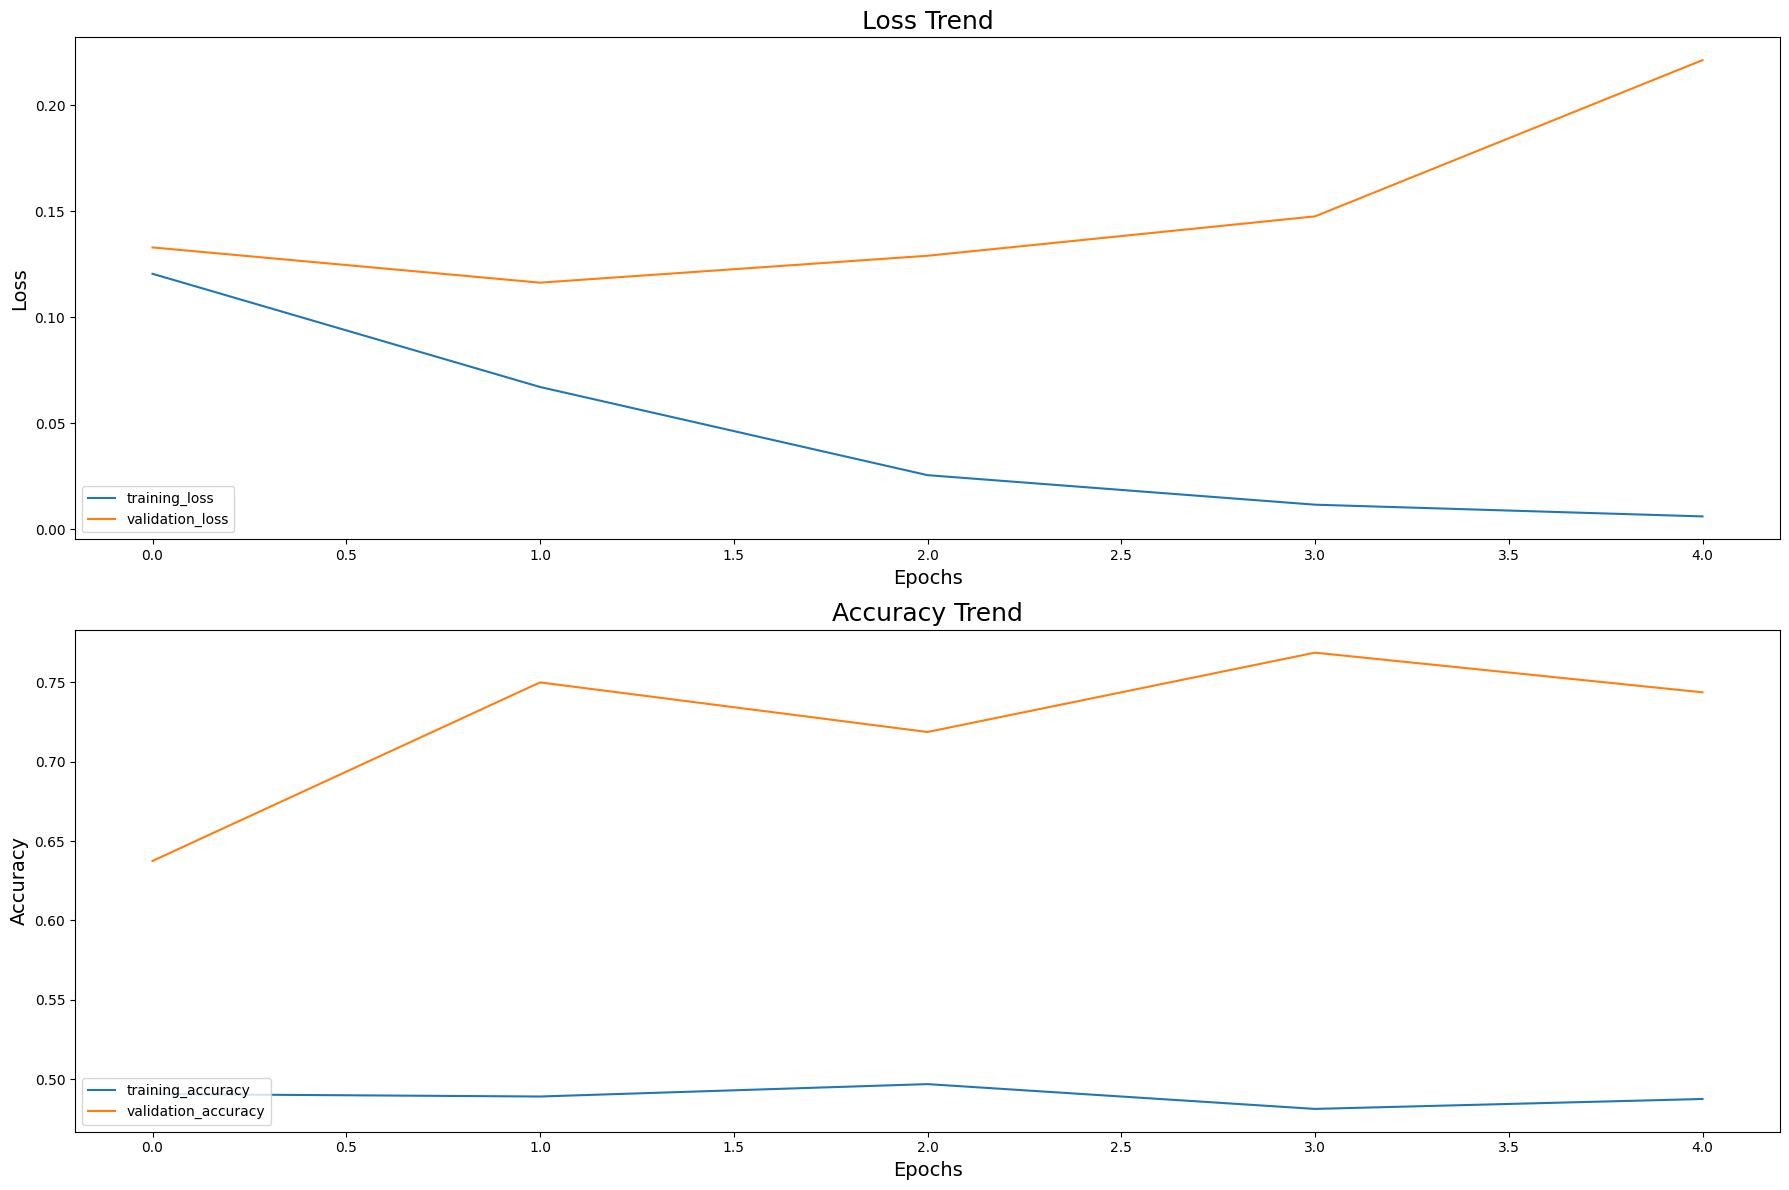

In [45]:
plot_training_scores(scores1)

In [47]:
pt_save_directory = './saved_models/bert_ita'
saved_model = AutoModelForSequenceClassification.from_pretrained(pt_save_directory).to(device)
_, metrics1 = testing_network(saved_model, test_dataloader)
for i in metrics1:
    print(f'{i.upper():>10}: {metrics1[i]:.4f}')

  ACCURACY: 0.7900
 PRECISION: 0.7692
        F1: 0.8108
    RECALL: 0.8571


### UMBERTO

In [51]:
tokenizer = AutoTokenizer.from_pretrained("Musixmatch/umberto-commoncrawl-cased-v1", model_max_length=512)

tokenized_datasets = myCustomDataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(['File', 'Engagement', 'Manipulation', 'Visual', 'Text'])
tokenized_datasets = tokenized_datasets.rename_column('Hate Speech', 'labels')
tokenized_datasets.set_format("torch")

print(tokenized_datasets)

train_dataloader = DataLoader(tokenized_datasets['train'], shuffle=True, batch_size=10)
eval_dataloader = DataLoader(tokenized_datasets['eval'], batch_size=10)
test_dataloader = DataLoader(tokenized_datasets['test'])
train_labels = tokenized_datasets['train'][:]['labels']
eval_labels = tokenized_datasets['eval'][:]['labels']
num_epochs = 5

Loading cached processed dataset at /Users/albertogvalerio/.cache/huggingface/datasets/csv/default-b4b0aa8d7fa28b57/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d/cache-300e02937637fcaa.arrow


Map:   0%|          | 0/160 [00:00<?, ? examples/s]

Loading cached processed dataset at /Users/albertogvalerio/.cache/huggingface/datasets/csv/default-27d1b7e2c5d74982/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d/cache-ec324b15ea62c3e6.arrow


DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 640
    })
    eval: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 160
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 200
    })
})


In [51]:
model = AutoModelForSequenceClassification.from_pretrained("Musixmatch/umberto-commoncrawl-cased-v1", num_labels=2).to(device)
pt_save_directory = None #'./saved_models/umberto'
scores2, _ = training_network(model, train_dataloader, eval_dataloader, train_labels, eval_labels, num_epochs, pt_save_directory)

Some weights of the model checkpoint at Musixmatch/umberto-commoncrawl-cased-v1 were not used when initializing CamembertForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at Musixmatch/umberto-commoncrawl-cased-v1 and

  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 1/5 | Train loss: 0.13660, Eval loss: 0.12462, Train Acc: 0.54531, Eval Acc: 0.64375
EPOCH: 2/5 | Train loss: 0.10519, Eval loss: 0.10928, Train Acc: 0.49375, Eval Acc: 0.75000
EPOCH: 3/5 | Train loss: 0.06183, Eval loss: 0.12533, Train Acc: 0.49219, Eval Acc: 0.75625
EPOCH: 4/5 | Train loss: 0.04639, Eval loss: 0.12537, Train Acc: 0.49375, Eval Acc: 0.76250
EPOCH: 5/5 | Train loss: 0.04413, Eval loss: 0.17486, Train Acc: 0.47813, Eval Acc: 0.75000


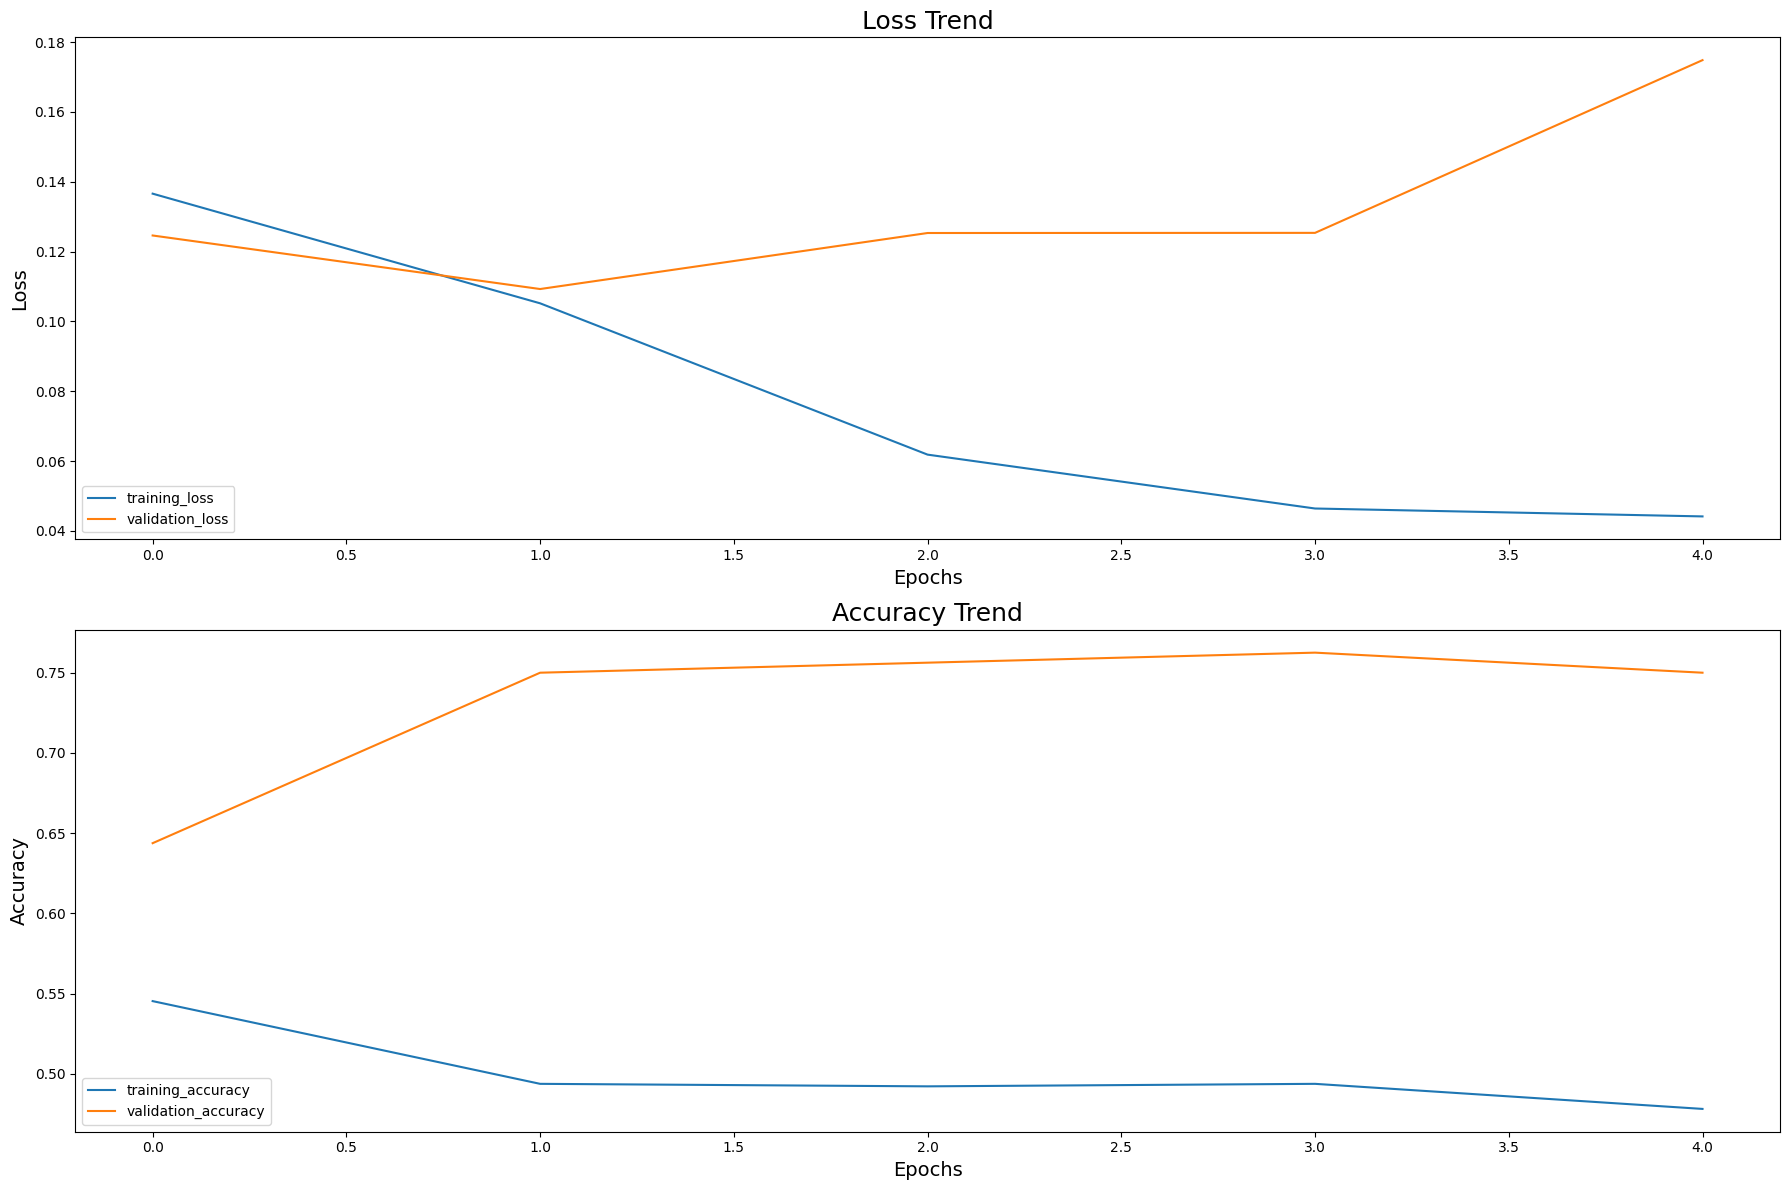

In [52]:
plot_training_scores(scores2)

In [52]:
pt_save_directory = './saved_models/umberto'
saved_model = AutoModelForSequenceClassification.from_pretrained(pt_save_directory).to(device)
_, metrics2 = testing_network(saved_model, test_dataloader)
for i in metrics2:
    print(f'{i.upper():>10}: {metrics2[i]:.4f}')

  ACCURACY: 0.7600
 PRECISION: 0.9130
        F1: 0.7241
    RECALL: 0.6000


### FEEL-IT

In [54]:
tokenizer = AutoTokenizer.from_pretrained("MilaNLProc/feel-it-italian-emotion", model_max_length=512)

tokenized_datasets = myCustomDataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(['File', 'Engagement', 'Manipulation', 'Visual', 'Text'])
tokenized_datasets = tokenized_datasets.rename_column('Hate Speech', 'labels')
tokenized_datasets.set_format("torch")

print(tokenized_datasets)

train_dataloader = DataLoader(tokenized_datasets['train'], shuffle=True, batch_size=10)
eval_dataloader = DataLoader(tokenized_datasets['eval'], batch_size=10)
test_dataloader = DataLoader(tokenized_datasets['test'])
train_labels = tokenized_datasets['train'][:]['labels']
eval_labels = tokenized_datasets['eval'][:]['labels']
num_epochs = 5

Loading cached processed dataset at /Users/albertogvalerio/.cache/huggingface/datasets/csv/default-b4b0aa8d7fa28b57/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d/cache-977e42d9079da669.arrow


Map:   0%|          | 0/160 [00:00<?, ? examples/s]

Loading cached processed dataset at /Users/albertogvalerio/.cache/huggingface/datasets/csv/default-27d1b7e2c5d74982/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d/cache-04d1060a6cbfe40e.arrow


DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 640
    })
    eval: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 160
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 200
    })
})


In [55]:
model = AutoModelForSequenceClassification.from_pretrained("MilaNLProc/feel-it-italian-emotion", num_labels=2, ignore_mismatched_sizes=True).to(device)
pt_save_directory = None #'./saved_models/feel_it'
scores3, _ = training_network(model, train_dataloader, eval_dataloader, train_labels, eval_labels, num_epochs, pt_save_directory)

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at MilaNLProc/feel-it-italian-emotion and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([4, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 1/5 | Train loss: 0.11262, Eval loss: 0.11718, Train Acc: 0.52344, Eval Acc: 0.70625
EPOCH: 2/5 | Train loss: 0.08696, Eval loss: 0.14913, Train Acc: 0.50938, Eval Acc: 0.66250
EPOCH: 3/5 | Train loss: 0.06944, Eval loss: 0.10614, Train Acc: 0.50781, Eval Acc: 0.79375
EPOCH: 4/5 | Train loss: 0.05087, Eval loss: 0.20357, Train Acc: 0.50313, Eval Acc: 0.62500
EPOCH: 5/5 | Train loss: 0.04982, Eval loss: 0.10851, Train Acc: 0.50625, Eval Acc: 0.80000


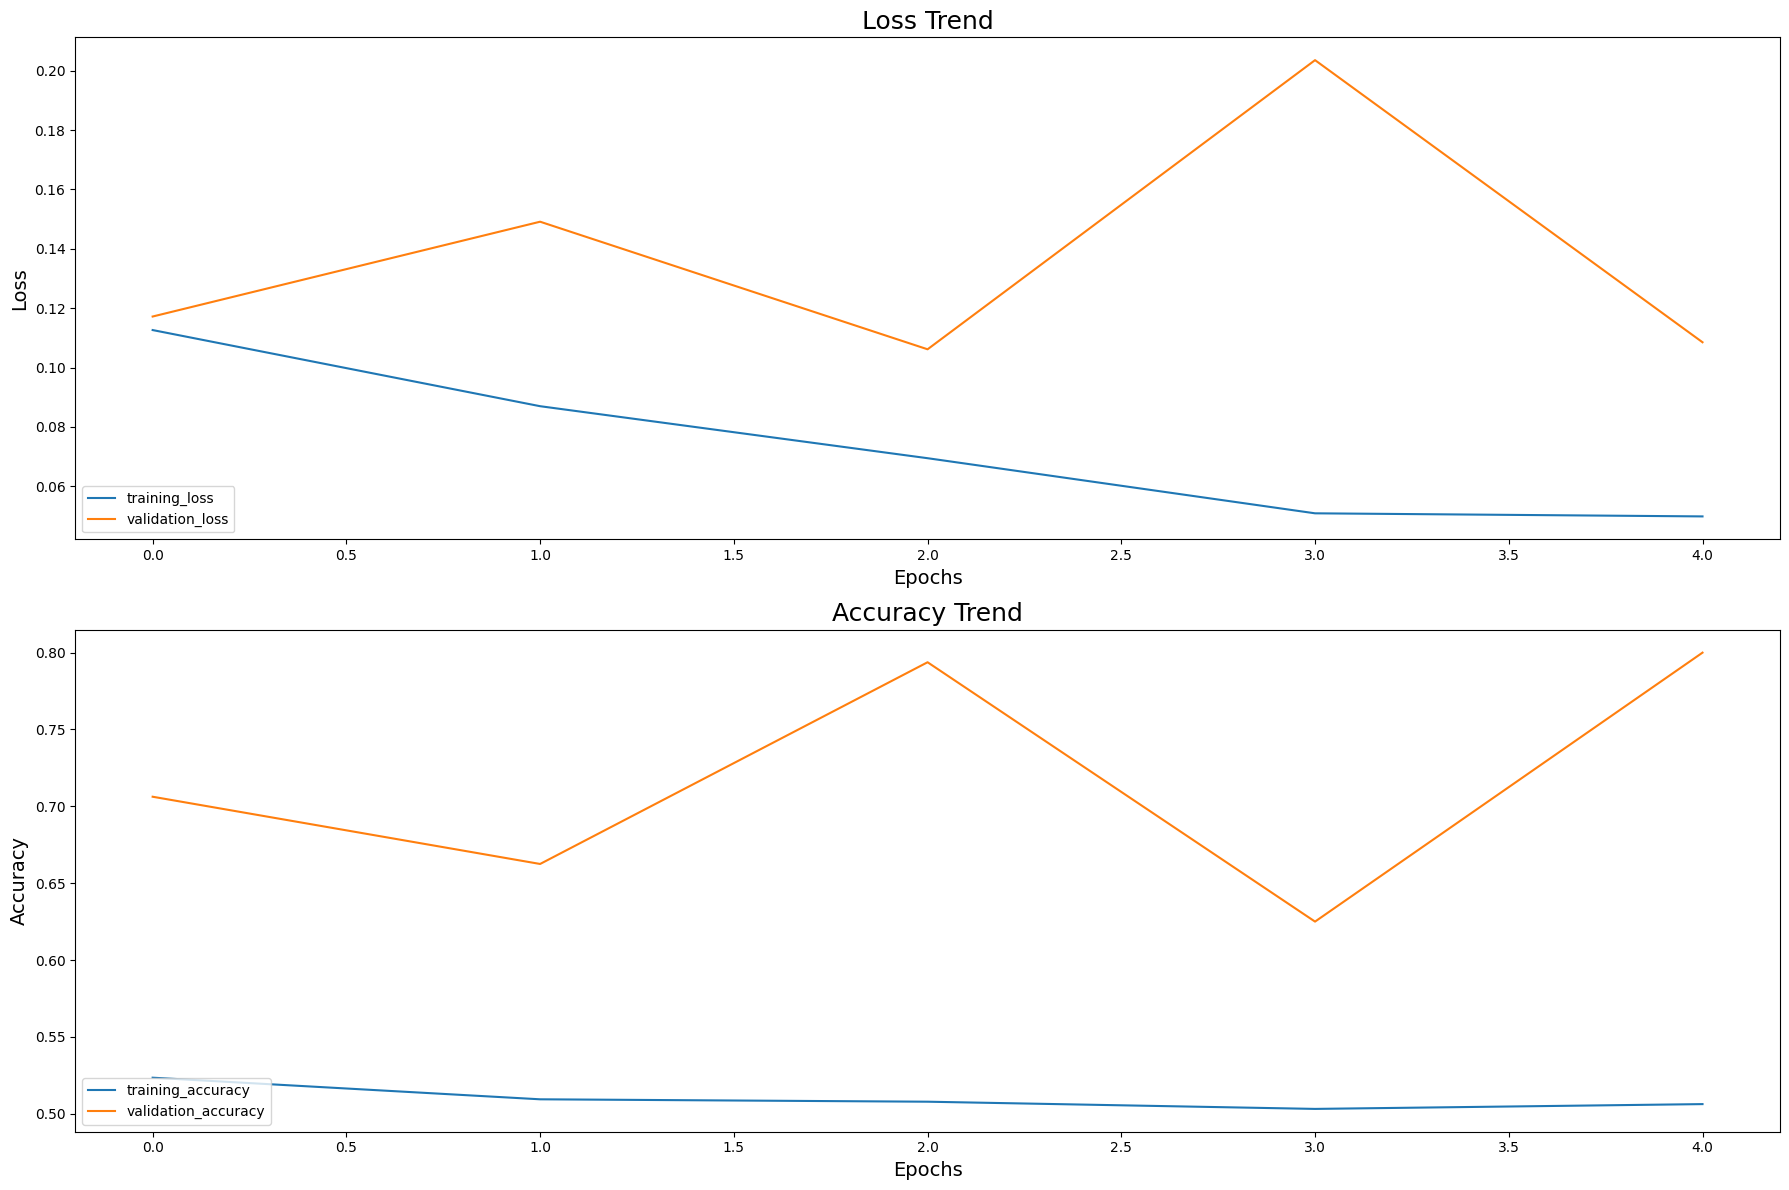

In [56]:
plot_training_scores(scores3)

In [55]:
pt_save_directory = './saved_models/feel_it'
saved_model = AutoModelForSequenceClassification.from_pretrained(pt_save_directory).to(device)
_, metrics3 = testing_network(saved_model, test_dataloader)
for i in metrics3:
    print(f'{i.upper():>10}: {metrics3[i]:.4f}')

  ACCURACY: 0.8200
 PRECISION: 0.8966
        F1: 0.8125
    RECALL: 0.7429


### ROBERTA

In [57]:
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-xlm-roberta-base", model_max_length=512)

tokenized_datasets = myCustomDataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(['File', 'Engagement', 'Manipulation', 'Visual', 'Text'])
tokenized_datasets = tokenized_datasets.rename_column('Hate Speech', 'labels')
tokenized_datasets.set_format("torch")

print(tokenized_datasets)

train_dataloader = DataLoader(tokenized_datasets['train'], shuffle=True, batch_size=10)
eval_dataloader = DataLoader(tokenized_datasets['eval'], batch_size=10)
test_dataloader = DataLoader(tokenized_datasets['test'])
train_labels = tokenized_datasets['train'][:]['labels']
eval_labels = tokenized_datasets['eval'][:]['labels']
num_epochs = 5

Loading cached processed dataset at /Users/albertogvalerio/.cache/huggingface/datasets/csv/default-b4b0aa8d7fa28b57/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d/cache-52c8086009c93171.arrow


Map:   0%|          | 0/160 [00:00<?, ? examples/s]

Loading cached processed dataset at /Users/albertogvalerio/.cache/huggingface/datasets/csv/default-27d1b7e2c5d74982/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d/cache-092aeeafd7472b9c.arrow


DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 640
    })
    eval: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 160
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 200
    })
})


In [59]:
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-xlm-roberta-base", num_labels=2).to(device)
pt_save_directory = None #'./saved_models/roberta'
scores4, _ = training_network(model, train_dataloader, eval_dataloader, train_labels, eval_labels, num_epochs, pt_save_directory)

Some weights of the model checkpoint at cardiffnlp/twitter-xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-xlm-roberta-base and are newly initialized: ['classifier.den

  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 1/5 | Train loss: 0.13012, Eval loss: 0.11547, Train Acc: 0.50469, Eval Acc: 0.65625
EPOCH: 2/5 | Train loss: 0.10197, Eval loss: 0.10233, Train Acc: 0.49844, Eval Acc: 0.73125
EPOCH: 3/5 | Train loss: 0.06656, Eval loss: 0.13415, Train Acc: 0.52969, Eval Acc: 0.76250
EPOCH: 4/5 | Train loss: 0.04321, Eval loss: 0.11813, Train Acc: 0.49375, Eval Acc: 0.79375
EPOCH: 5/5 | Train loss: 0.02556, Eval loss: 0.12037, Train Acc: 0.47813, Eval Acc: 0.78125


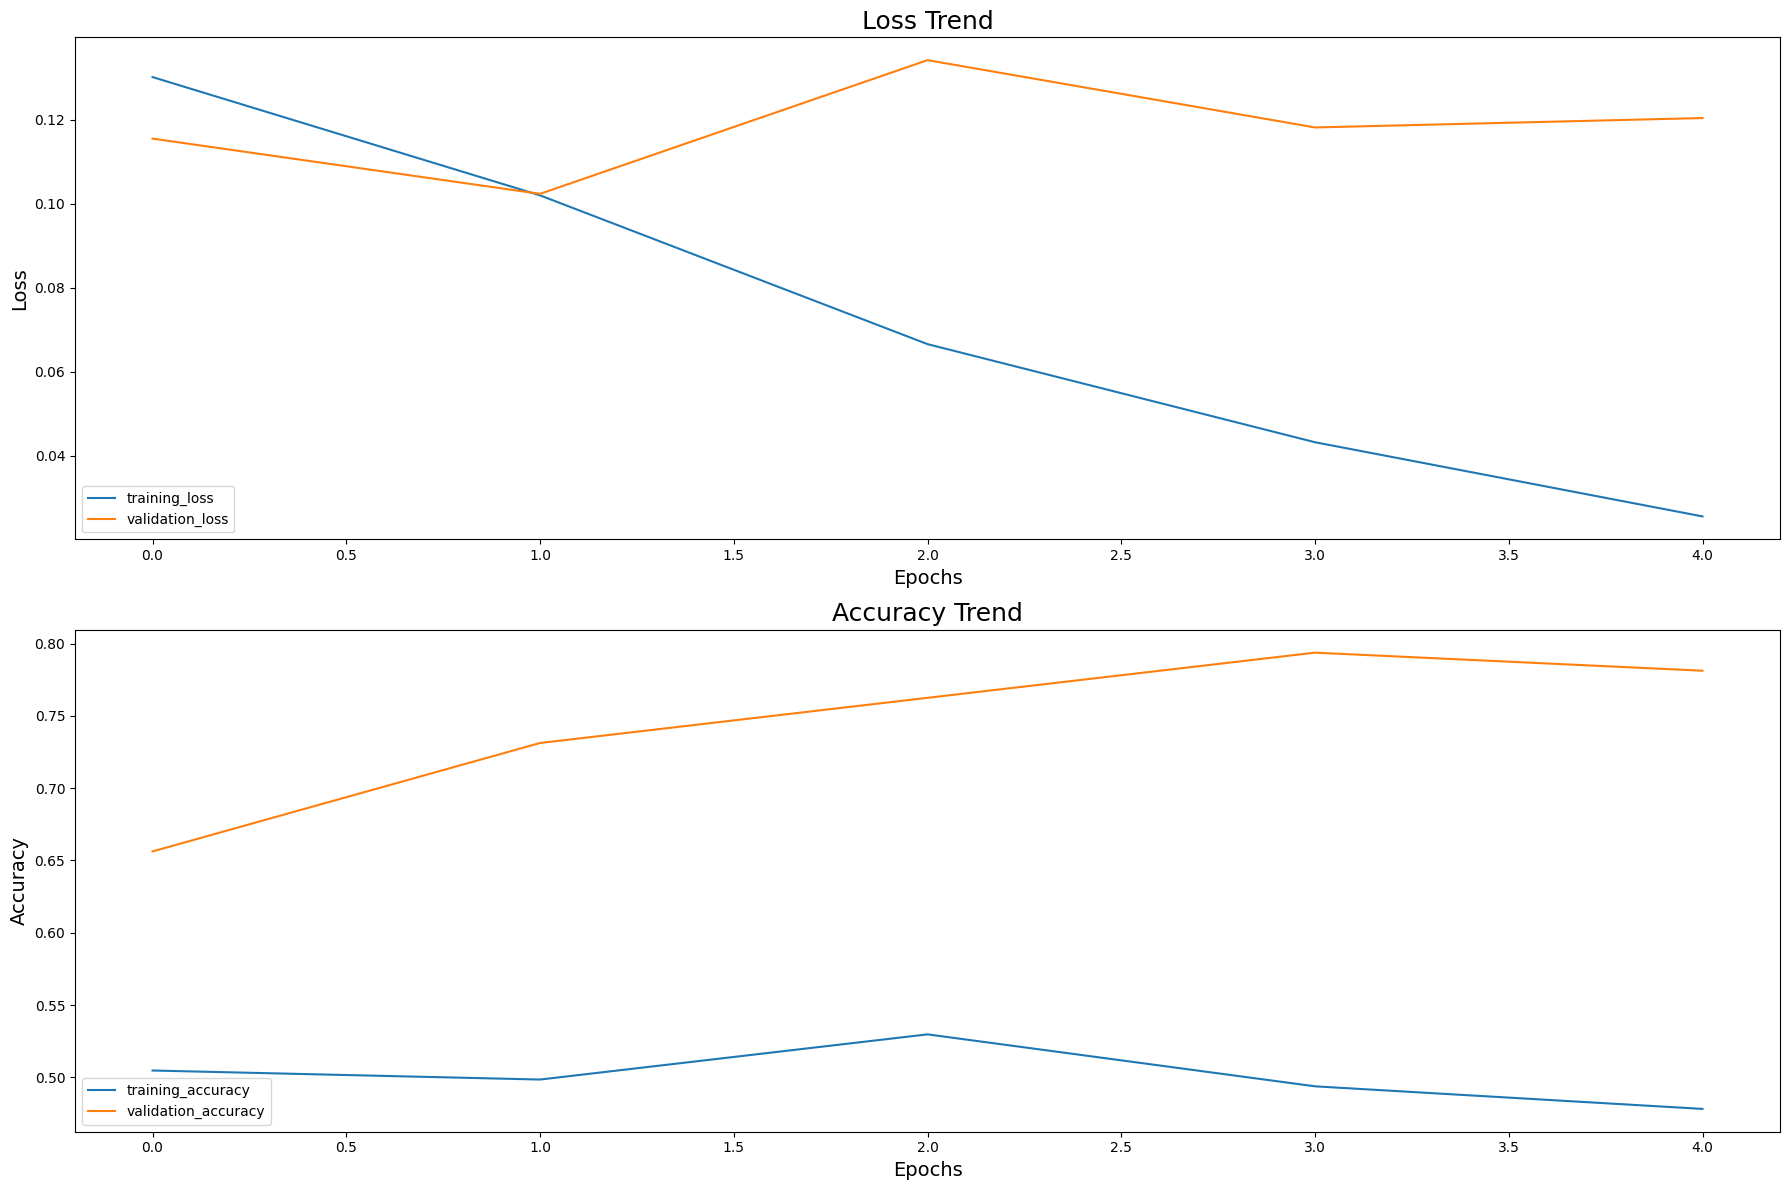

In [60]:
plot_training_scores(scores4)

In [58]:
pt_save_directory = './saved_models/roberta'
saved_model = AutoModelForSequenceClassification.from_pretrained(pt_save_directory).to(device)
_, metrics4 = testing_network(saved_model, test_dataloader)
for i in metrics4:
    print(f'{i.upper():>10}: {metrics3[i]:.4f}')

  ACCURACY: 0.8200
 PRECISION: 0.8966
        F1: 0.8125
    RECALL: 0.7429


### Models comparison

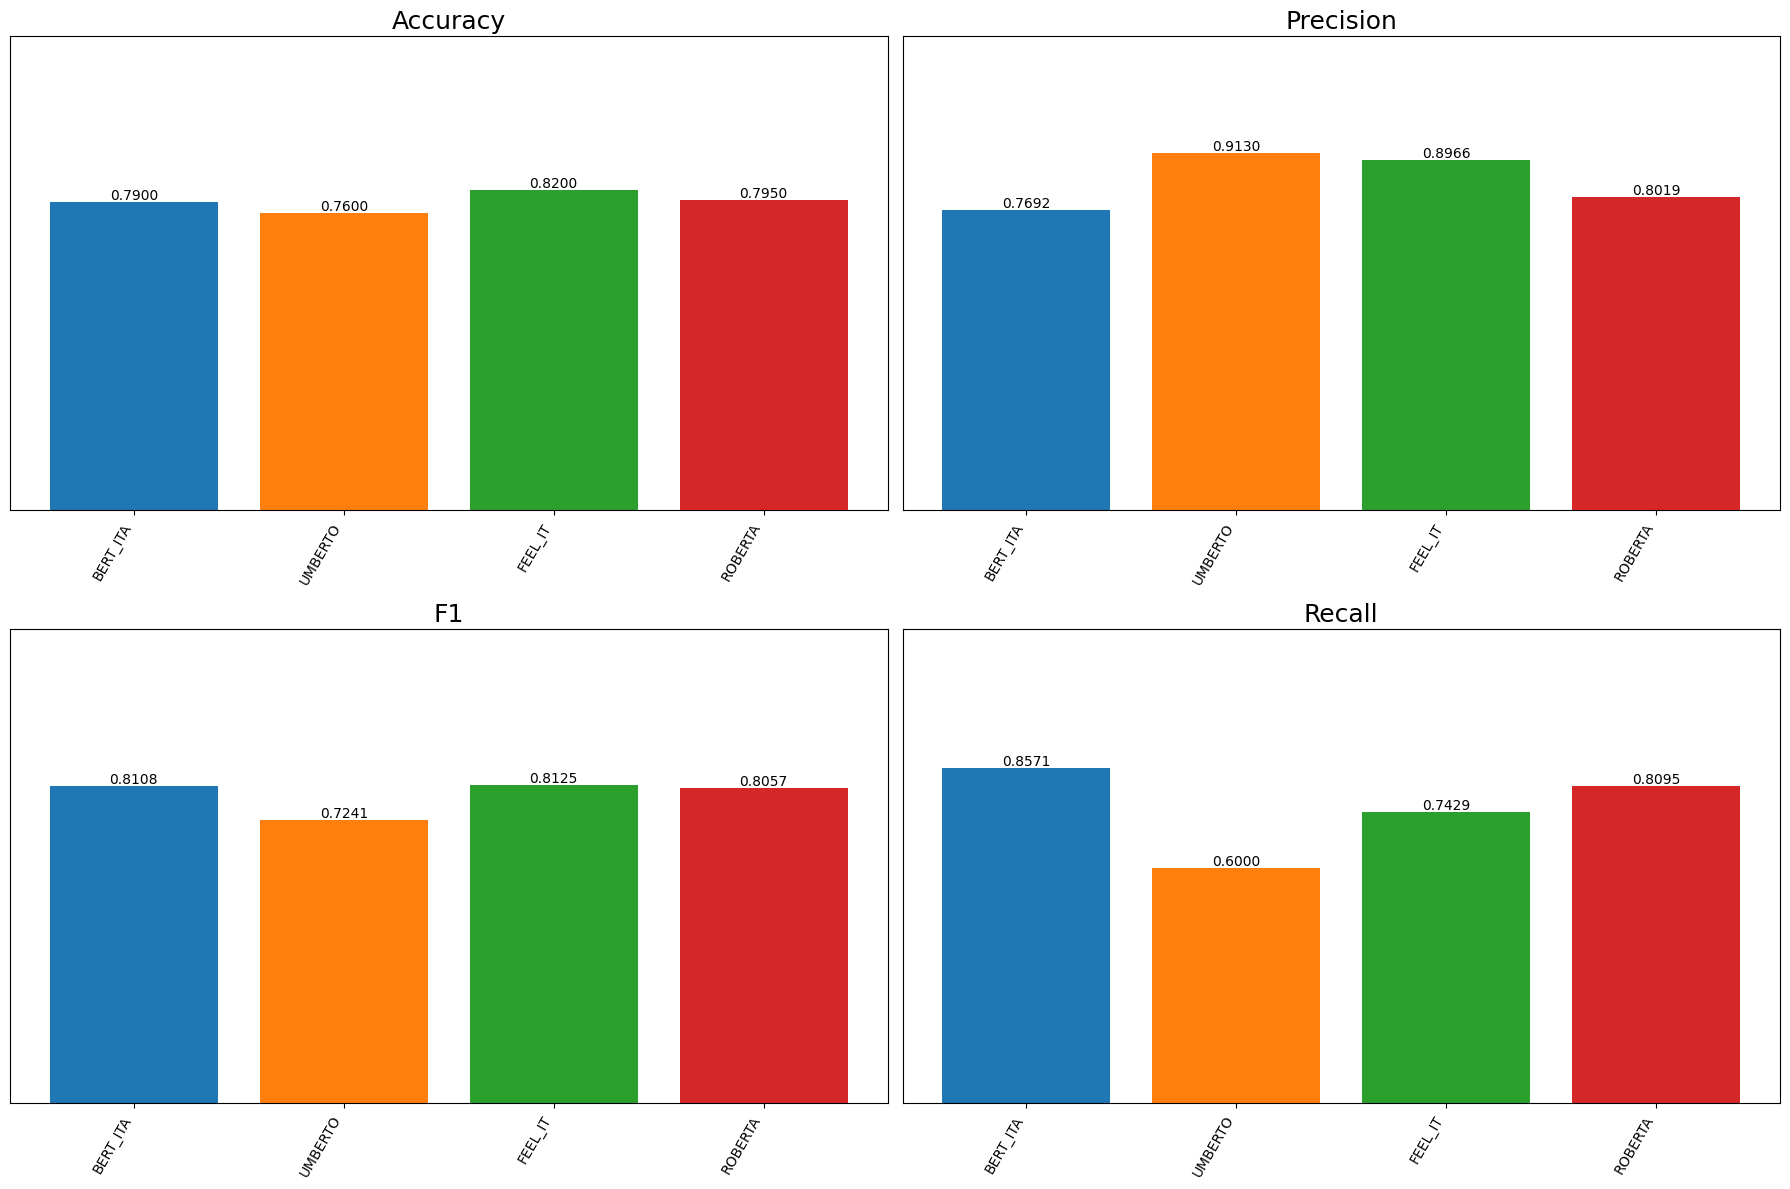

In [59]:
height1 = [metrics1['accuracy'],  metrics2['accuracy'],  metrics3['accuracy'],  metrics4['accuracy']]
height2 = [metrics1['precision'], metrics2['precision'], metrics3['precision'], metrics4['precision']]
height3 = [metrics1['f1'],        metrics2['f1'],        metrics3['f1'],        metrics4['f1']]
height4 = [metrics1['recall'],    metrics2['recall'],    metrics3['recall'],    metrics4['recall']]
labels = ['BERT_ITA', 'UMBERTO', 'FEEL_IT', 'ROBERTA']

fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))
colors = mcolors.TABLEAU_COLORS
bars1 = ax1.bar(labels, height=height1, color=colors)
for rect in bars1:
     height = rect.get_height()
     ax1.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.4f}', ha='center', va='bottom')
bars2 = ax2.bar(labels, height=height2, color=colors)
for rect in bars2:
     height = rect.get_height()
     ax2.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.4f}', ha='center', va='bottom')
bars3 = ax3.bar(labels, height=height3, color=colors)
for rect in bars3:
     height = rect.get_height()
     ax3.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.4f}', ha='center', va='bottom')
bars4 = ax4.bar(labels, height=height4, color=colors)
for rect in bars4:
     height = rect.get_height()
     ax4.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.4f}', ha='center', va='bottom')

ax1.set_yticks([])
ax2.set_yticks([])
ax3.set_yticks([])
ax4.set_yticks([])
ax1.set_title('Accuracy', fontsize = 18)
ax2.set_title('Precision', fontsize = 18)
ax3.set_title('F1', fontsize = 18)
ax4.set_title('Recall', fontsize = 18)
ax1.set_ylim(ymin=0, ymax=(max(height3)+.4))
ax2.set_ylim(ymin=0, ymax=(max(height3)+.4))
ax3.set_ylim(ymin=0, ymax=(max(height3)+.4))
ax4.set_ylim(ymin=0, ymax=(max(height3)+.4))
ax1.set_xticklabels(labels, rotation = 60, ha="right")
ax2.set_xticklabels(labels, rotation = 60, ha="right")
ax3.set_xticklabels(labels, rotation = 60, ha="right")
ax4.set_xticklabels(labels, rotation = 60, ha="right")
plt.tight_layout()
plt.show()

In [60]:
print(''.join(['> ' for i in range(40)]))
print(f'\n{"MODEL":<25}{"METRICS MEAN":>18}\n')
print(''.join(['> ' for i in range(40)]))
print(f'{"BERT_ITA:":<25}{np.mean([i for i in metrics1.values()]):>18.3f}')
print(f'{"UMBERTO:":<25}{np.mean([i for i in metrics2.values()]):>18.3f}')
print(f'\033[1m{"FEEL_IT:":<25}\033[0m\033[1m{np.mean([i for i in metrics3.values()]):>18.3f}\033[0m')
print(f'{"ROBERTA:":<25}{np.mean([i for i in metrics4.values()]):>18.3f}')

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

MODEL                          METRICS MEAN

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 
BERT_ITA:                             0.807
UMBERTO:                              0.749
FEEL_IT:                              0.818
ROBERTA:                              0.803


## Images model

In [66]:
embeddings_train = pd.read_csv(BASE_PATHS[1] + FILENAMES[4], header=None)
embeddings_train['Train Embeddings'] = [np.array(i.split()).astype(np.float32) for i in embeddings_train.loc[:][1]]
embeddings_train['Labels'] = data['Hate Speech']
embeddings_train = embeddings_train[['Train Embeddings','Labels']]
embeddings_train.head()

,Train Embeddings,Labels
0,"[0.03371752, 0.71383077, 0.1622142, 0.15153012...",1
1,"[0.017445266, 0.01675424, 0.06025219, 0.088076...",0
2,"[0.2331691, 2.1796272, 0.0, 0.004503002, 1.169...",1
3,"[0.09365508, 1.8714182, 0.5247863, 0.039612748...",1
4,"[0.12720379, 1.260958, 0.1069836, 0.27789292, ...",0


In [68]:
embeddings_test = pd.read_csv(BASE_PATHS[4] + FILENAMES[10], header=None)
embeddings_test['Test Embeddings'] = [np.array(i.split()).astype(np.float32) for i in embeddings_test.loc[:][1]]
goldData = pd.read_csv(BASE_PATHS[4] + FILENAMES[14])
embeddings_test['Labels'] = goldData['Hate Speech']
embeddings_test = embeddings_test[['Test Embeddings', 'Labels']]
embeddings_test.head()

,Test Embeddings,Labels
0,"[0.27691776, 0.952373, 0.06241767, 0.58647937,...",1
1,"[0.07759489, 1.8289204, 1.7770578, 0.07402565,...",0
2,"[0.28806925, 1.3223957, 0.07227258, 0.24837093...",1
3,"[0.3849284, 0.94429594, 0.8429149, 0.53647035,...",0
4,"[0.06668279, 0.85113406, 0.40766233, 0.3558357...",1


In [94]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

class MySimpleNetworkClassifier(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.layer1 = nn.Linear(input_size, 1024)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(1024, 512)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(512, 128)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(128, 1)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.tanh(self.output(x))
        return x

In [70]:
def fit_NN(net, X_train_net, X_eval_net, y_train_net, y_eval_net, n_epochs, batch=100, optimizer=None, verbose=(False,1)):

    torch.manual_seed(42)
    loss_fn = nn.BCEWithLogitsLoss()
    if optimizer is None:
        optimizer = torch.optim.SGD(params=net.parameters(), lr=.1)
    scores = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    num_training_steps = n_epochs * len(X_train_net)
    num_validation_steps = n_epochs * len(X_eval_net)

    for epoch in range(n_epochs):
        ### Training
        net.train()
        trainLosses = 0
        evalLosses = 0
        trainPred = []
        evalPred = []
        if batch is None:
            batch = len(X_train_net)
        for i in range(0, len(X_train_net), batch):
            X_train = X_train_net[i:i+batch]
            y_train = y_train_net[i:i+batch]
            # 1. Forward pass (model outputs raw logits)
            y_logits = net(X_train).squeeze() # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device
            y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labls
            # 2. Calculate loss
            loss = loss_fn(y_logits, y_train) # Using nn.BCEWithLogitsLoss works with raw logits
            trainLosses += loss
            trainPred += y_pred.detach().cpu().numpy().tolist()
            # 3. Optimizer zero grad
            optimizer.zero_grad()
            # 4. Loss backwards
            loss.backward()
            # 5. Optimizer step
            optimizer.step()

        ### Evaluation
        with torch.inference_mode():
            net.eval()
            if batch is None:
                batch = len(X_eval_net)
            # 1. Forward pass
            for i in range(0, len(X_eval_net), batch):
                X_eval = X_eval_net[i:i+batch]
                y_eval = y_eval_net[i:i+batch]
                test_logits = net(X_eval).squeeze()
                test_pred = torch.round(torch.sigmoid(test_logits))
                # 2. Caculate loss
                test_loss = loss_fn(test_logits, y_eval)
                evalLosses += test_loss
                evalPred += test_pred.detach().cpu().numpy().tolist()

        avgTrainLoss = trainLosses / num_training_steps
        avgValLoss = evalLosses / num_validation_steps
        scores['train_loss'].append(avgTrainLoss.detach().cpu().numpy())
        scores['val_loss'].append(avgValLoss.detach().cpu().numpy())
        acc_train = accuracy_fn(y_true=y_train_net, y_pred=torch.tensor(trainPred).to(device))
        acc_eval = accuracy_fn(y_true=y_eval_net, y_pred=torch.tensor(evalPred).to(device))
        scores['train_acc'].append(acc_train)
        scores['val_acc'].append(acc_eval)

        # Print out what's happening every 100 epochs
        if epoch % verbose[1] == 0 and verbose[0] == True:
            print(f"Epoch: {epoch} | Train Loss: {avgTrainLoss*10000:.5f}, Train Accuracy: {acc_train:.2f}% | Eval loss: {avgValLoss*10000:.5f}, Eval acc: {acc_eval:.2f}%")
    
    return net, scores

In [71]:
def predict_NN(net, X_test_net, y_test_net):
    torch.manual_seed(42)
    net.eval()
    with torch.no_grad():
        test_logits = net(X_test_net).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_acc = accuracy_fn(y_true=y_test_net, y_pred=test_pred)
    return test_acc, test_pred

In [78]:
# Preparing the data
n_features = len(embeddings_train['Train Embeddings'][0])
X_train_net = np.array([i for i in embeddings_train['Train Embeddings'].values])
y_train_net = embeddings_train['Labels'].to_numpy()
X_test_net = np.array([i for i in embeddings_test['Test Embeddings'].values])
y_test_net = embeddings_test['Labels'].to_numpy()
split = int(len(X_train_net) * .8)
X_eval_net = X_train_net[split:]
y_eval_net = y_train_net[split:]
X_train_net = X_train_net[:split]
y_train_net = y_train_net[:split]

X_train_net = torch.tensor(data = X_train_net.reshape(len(X_train_net), n_features), dtype=torch.float32).to(device)
X_eval_net = torch.tensor(data = X_eval_net.reshape(len(X_eval_net), n_features), dtype=torch.float32).to(device)
X_test_net = torch.tensor(data = X_test_net.reshape(len(X_test_net), n_features), dtype=torch.float32).to(device)
y_train_net = torch.tensor(data = y_train_net, dtype=torch.float32).to(device)
y_eval_net = torch.tensor(data = y_eval_net, dtype=torch.float32).to(device)
y_test_net = torch.tensor(data = y_test_net, dtype=torch.float32).to(device)

print("Training Shape: ", X_train_net.shape, y_train_net.shape)
print("Evaluation Shape: ", X_eval_net.shape, y_eval_net.shape)
print("Testing Shape: ", X_test_net.shape, y_test_net.shape) 

Training Shape:  torch.Size([640, 2048]) torch.Size([640])
Evaluation Shape:  torch.Size([160, 2048]) torch.Size([160])
Testing Shape:  torch.Size([200, 2048]) torch.Size([200])


In [79]:
net = MySimpleNetworkClassifier(n_features).to(device)
model, metrics = fit_NN(net, X_train_net, X_eval_net, y_train_net, y_eval_net, n_epochs=6, batch=10, verbose=(True,1))
accuracy_nn, pred = predict_NN(model, X_test_net, y_test_net)

Epoch: 0 | Train Loss: 115.90118, Train Accuracy: 49.53% | Eval loss: 114.79282, Eval acc: 55.00%
Epoch: 1 | Train Loss: 115.43945, Train Accuracy: 52.66% | Eval loss: 114.23890, Eval acc: 55.00%
Epoch: 2 | Train Loss: 114.71732, Train Accuracy: 56.41% | Eval loss: 113.39787, Eval acc: 55.00%
Epoch: 3 | Train Loss: 113.63744, Train Accuracy: 58.59% | Eval loss: 112.20107, Eval acc: 56.25%
Epoch: 4 | Train Loss: 112.07661, Train Accuracy: 58.28% | Eval loss: 110.11852, Eval acc: 58.13%
Epoch: 5 | Train Loss: 110.04945, Train Accuracy: 61.88% | Eval loss: 108.47815, Eval acc: 63.12%


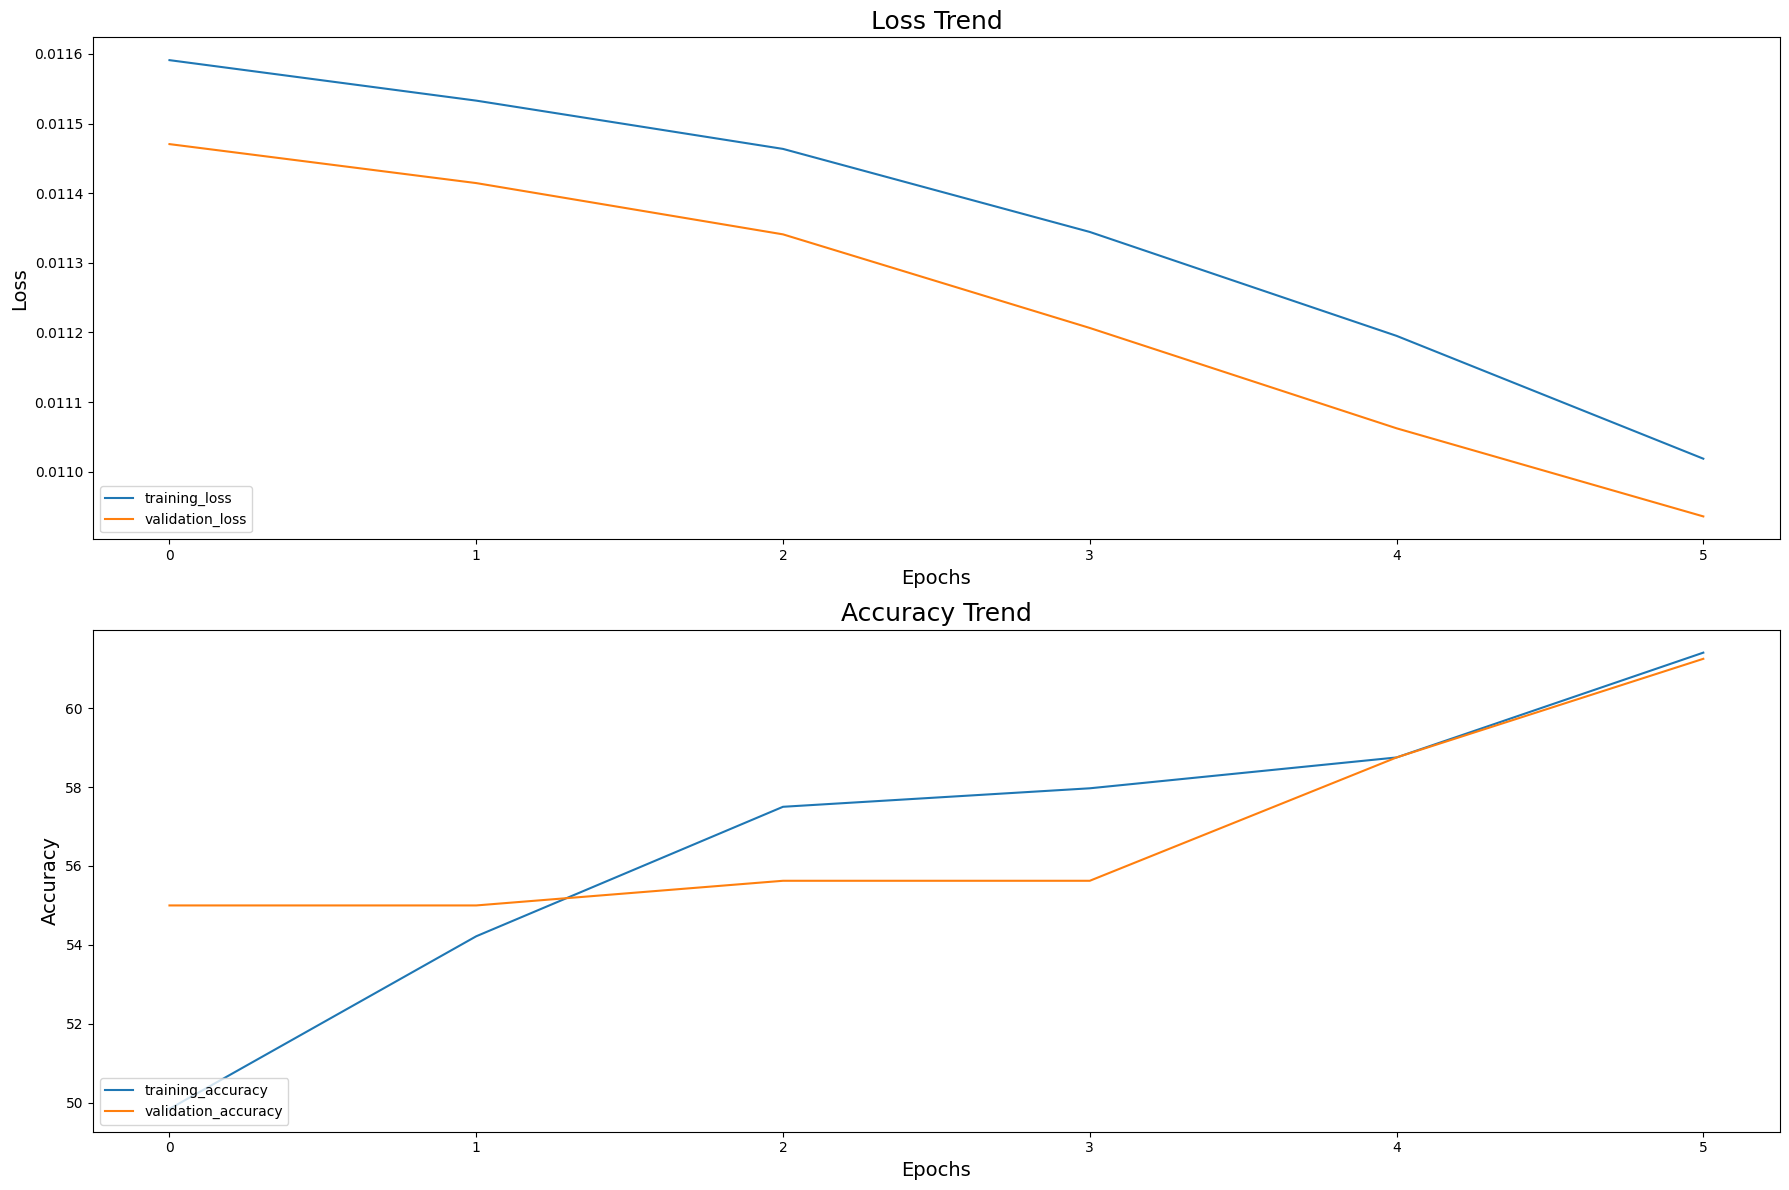

In [74]:
plot_training_scores(metrics)

In [80]:
print(f'\nTest Accuracy:\033[32m \033[01m {accuracy_nn:.2f}% \033[30m \033[0m')
print(classification_report(y_test_net.detach().cpu().numpy(), pred.detach().cpu().numpy(), target_names=['no_hate', 'hate']))


Test Accuracy:  53.50%  
              precision    recall  f1-score   support

     no_hate       0.51      0.78      0.61        95
        hate       0.61      0.31      0.42       105

    accuracy                           0.54       200
   macro avg       0.56      0.55      0.51       200
weighted avg       0.56      0.54      0.51       200



## Metadata model

In [81]:
### TRAINING SET FEATURES SELECTION
metadata_train = data[['Engagement', 'Manipulation', 'Hate Score', 'Nr Words', 'Nr Tokens', 'Hate Speech']]
metadata_train.head()

,Engagement,Manipulation,Hate Score,Nr Words,Nr Tokens,Hate Speech
0,381,0,NaN,15,8,1
1,142,1,NaN,14,7,0
2,3598,1,7.0,17,10,1
3,165,1,-37.0,9,3,1
4,44,0,NaN,26,21,0


In [87]:
### TEST SET FEATURES EXTRACTION AND SELECTION
metadata_test = pd.read_csv(BASE_PATHS[4] + FILENAMES[14])

# Tokens
metadata_test['Tokens'] = metadata_test['Text'].apply(lambda x:' '.join(my_preprocessing(x)))

# Hate score
metadata_test['Hate Score'] = metadata_test['Visual'].apply(lambda x:get_hate_score(x, df3))

# Nr of words
metadata_test['Nr Words'] = metadata_test['Text'].apply(lambda x:len(str(x).split()))

# Nr of words
metadata_test['Nr Tokens'] = metadata_test['Tokens'].apply(lambda x:len(str(x).split()))

metadata_test = metadata_test[['Engagement', 'Manipulation', 'Hate Score', 'Nr Words', 'Nr Tokens', 'Hate Speech']]
metadata_test.head()

,Engagement,Manipulation,Hate Score,Nr Words,Nr Tokens,Hate Speech
0,41,0,NaN,5,4,1
1,7,1,-30.0,8,4,0
2,22,0,-2.0,12,5,1
3,137,1,13.0,17,10,0
4,2667,0,2.0,6,3,1


In [88]:
### DATA NORMALIZATION
scaler = MinMaxScaler()

metadata_train['Engagement'] = scaler.fit_transform(metadata_train['Engagement'].values.reshape(-1, 1))
metadata_train['Nr Words'] = scaler.fit_transform(metadata_train['Nr Words'].values.reshape(-1, 1))
metadata_train['Nr Tokens'] = scaler.fit_transform(metadata_train['Nr Words'].values.reshape(-1, 1))
metadata_train['Hate Score'] = metadata_train['Hate Score'].fillna(0)
metadata_train['Hate Score'] = scaler.fit_transform(metadata_train['Hate Score'].values.reshape(-1, 1))

metadata_test['Engagement'] = scaler.fit_transform(metadata_test['Engagement'].values.reshape(-1, 1))
metadata_test['Nr Words'] = scaler.fit_transform(metadata_test['Nr Words'].values.reshape(-1, 1))
metadata_test['Nr Tokens'] = scaler.fit_transform(metadata_test['Nr Words'].values.reshape(-1, 1))
metadata_test['Hate Score'] = metadata_test['Hate Score'].fillna(0)
metadata_test['Hate Score'] = scaler.fit_transform(metadata_test['Hate Score'].values.reshape(-1, 1))
metadata_test.head()

,Engagement,Manipulation,Hate Score,Nr Words,Nr Tokens,Hate Speech
0,0.001491,0,0.355769,0.042553,0.042553,1
1,0.000224,1,0.067308,0.074468,0.074468,0
2,0.000783,0,0.336538,0.117021,0.117021,1
3,0.005069,1,0.480769,0.170213,0.170213,0
4,0.099370,0,0.375000,0.053191,0.053191,1


In [89]:
### DATA SPLITTING
n_features = 5
X_train_net = metadata_train[['Engagement', 'Manipulation', 'Hate Score', 'Nr Words', 'Nr Tokens']].to_numpy()
y_train_net = metadata_train['Hate Speech'].to_numpy()
X_test_net = metadata_test[['Engagement', 'Manipulation', 'Hate Score', 'Nr Words', 'Nr Tokens']].to_numpy()
y_test_net = metadata_test['Hate Speech'].to_numpy()
split = int(len(X_train_net) * .8)
X_eval_net = X_train_net[split:]
y_eval_net = y_train_net[split:]
X_train_net = X_train_net[:split]
y_train_net = y_train_net[:split]

X_train_net = torch.tensor(data = X_train_net.reshape(len(X_train_net), n_features), dtype=torch.float32).to(device)
X_eval_net = torch.tensor(data = X_eval_net.reshape(len(X_eval_net), n_features), dtype=torch.float32).to(device)
X_test_net = torch.tensor(data = X_test_net.reshape(len(X_test_net), n_features), dtype=torch.float32).to(device)
y_train_net = torch.tensor(data = y_train_net, dtype=torch.float32).to(device)
y_eval_net = torch.tensor(data = y_eval_net, dtype=torch.float32).to(device)
y_test_net = torch.tensor(data = y_test_net, dtype=torch.float32).to(device)

print("Training Shape: ", X_train_net.shape, y_train_net.shape)
print("Evaluation Shape: ", X_eval_net.shape, y_eval_net.shape)
print("Testing Shape: ", X_test_net.shape, y_test_net.shape) 

Training Shape:  torch.Size([640, 5]) torch.Size([640])
Evaluation Shape:  torch.Size([160, 5]) torch.Size([160])
Testing Shape:  torch.Size([200, 5]) torch.Size([200])


In [95]:
net = MySimpleNetworkClassifier(n_features).to(device)
model, metrics = fit_NN(net, X_train_net, X_eval_net, y_train_net, y_eval_net, n_epochs=100, batch=20, verbose=(True,10))
accuracy_nn, pred = predict_NN(model, X_test_net, y_test_net)

Epoch: 0 | Train Loss: 3.46331, Train Accuracy: 50.94% | Eval loss: 3.44343, Eval acc: 62.50%
Epoch: 10 | Train Loss: 3.40071, Train Accuracy: 55.31% | Eval loss: 3.36186, Eval acc: 55.00%
Epoch: 20 | Train Loss: 3.38191, Train Accuracy: 56.56% | Eval loss: 3.31318, Eval acc: 56.88%
Epoch: 30 | Train Loss: 3.37091, Train Accuracy: 57.03% | Eval loss: 3.30206, Eval acc: 55.62%
Epoch: 40 | Train Loss: 3.36418, Train Accuracy: 56.25% | Eval loss: 3.30274, Eval acc: 56.25%
Epoch: 50 | Train Loss: 3.35919, Train Accuracy: 56.72% | Eval loss: 3.30756, Eval acc: 54.37%
Epoch: 60 | Train Loss: 3.35565, Train Accuracy: 56.72% | Eval loss: 3.31269, Eval acc: 55.00%
Epoch: 70 | Train Loss: 3.35244, Train Accuracy: 58.44% | Eval loss: 3.31660, Eval acc: 55.62%
Epoch: 80 | Train Loss: 3.34938, Train Accuracy: 58.75% | Eval loss: 3.31826, Eval acc: 54.37%
Epoch: 90 | Train Loss: 3.34728, Train Accuracy: 59.53% | Eval loss: 3.32001, Eval acc: 54.37%


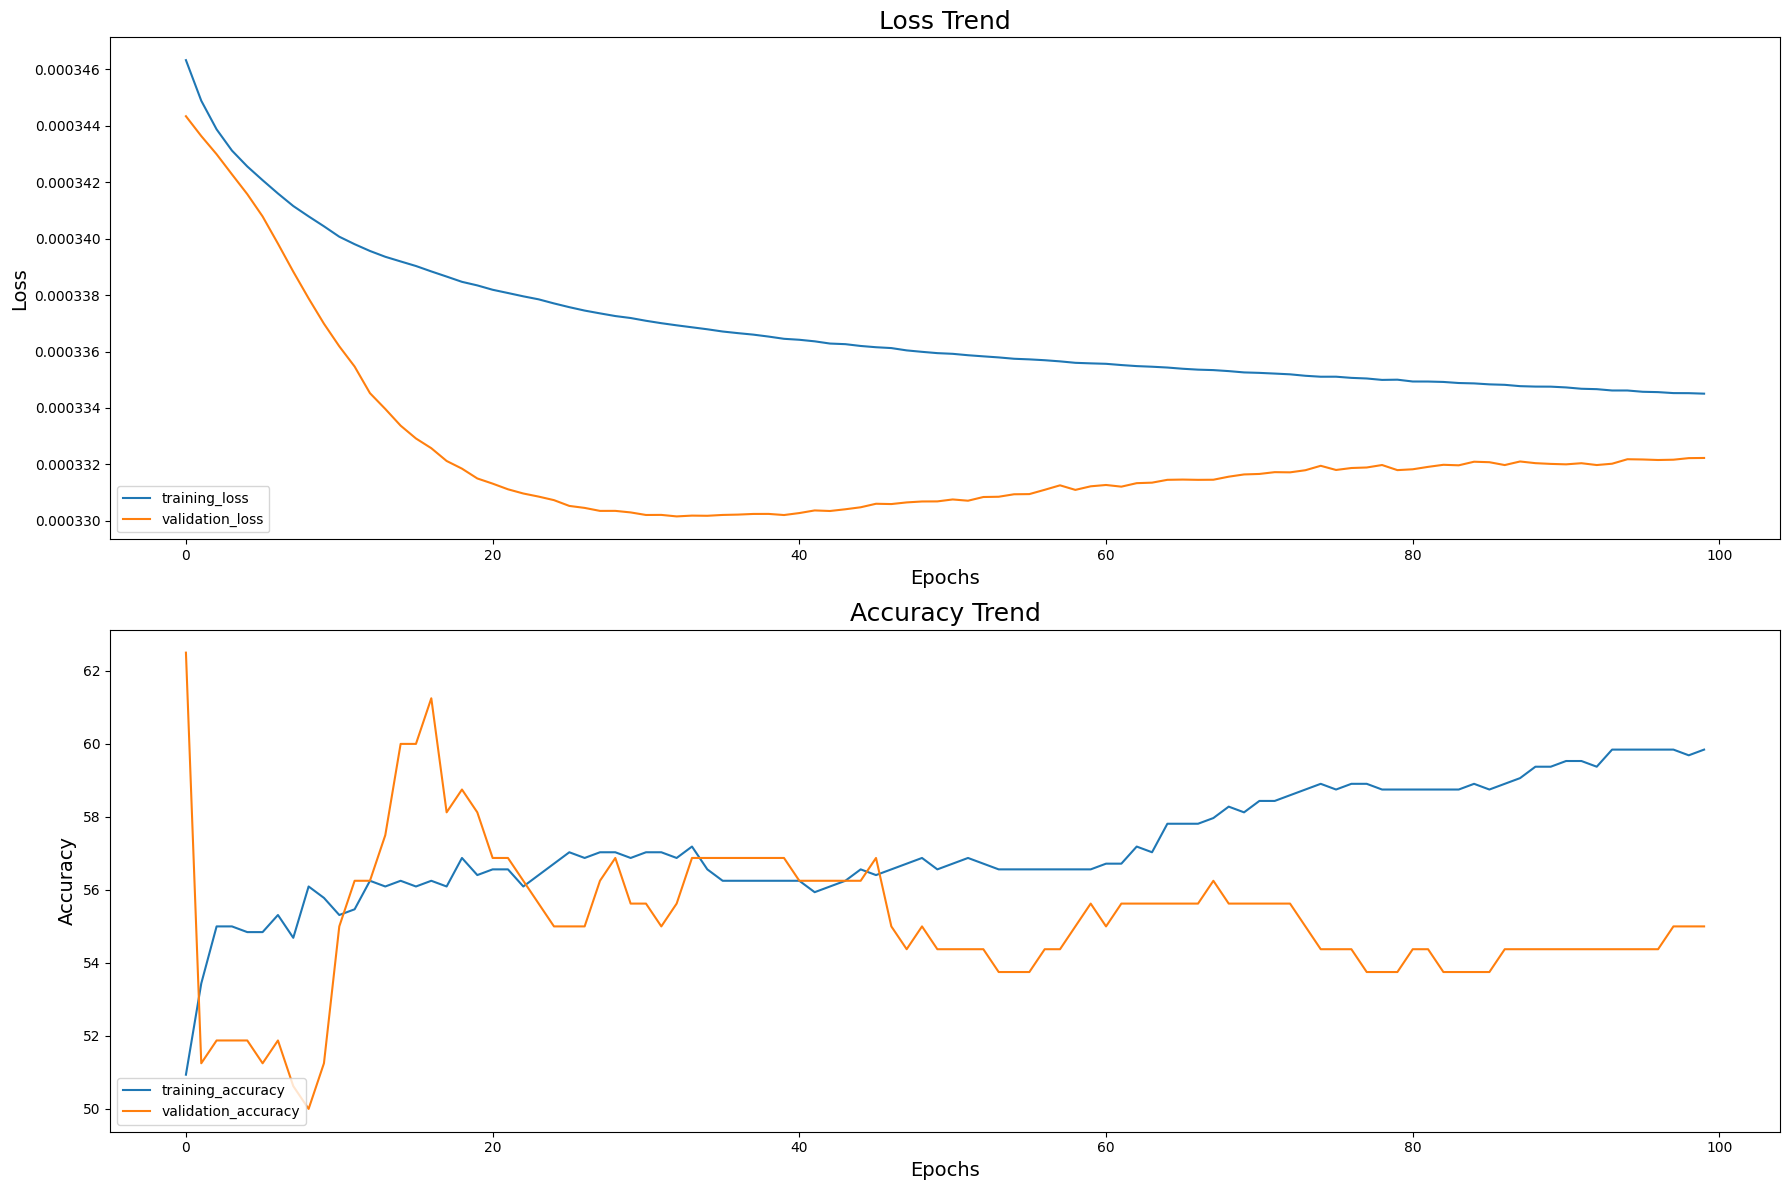

In [96]:
plot_training_scores(metrics)

In [97]:
print(f'\nTest Accuracy:\033[32m \033[01m {accuracy_nn:.2f}% \033[30m \033[0m')
print(classification_report(y_test_net.detach().cpu().numpy(), pred.detach().cpu().numpy(), target_names=['no_hate', 'hate']))


Test Accuracy:  62.00%  
              precision    recall  f1-score   support

     no_hate       0.65      0.43      0.52        95
        hate       0.61      0.79      0.69       105

    accuracy                           0.62       200
   macro avg       0.63      0.61      0.60       200
weighted avg       0.63      0.62      0.61       200



# EXPERIMENTAL PLAYGROUND

---

In [133]:
### GETTING DATA
myCustomDataset = DatasetDict({
    'train': load_dataset('csv', data_files=(BASE_PATHS[1] + FILENAMES[1]), split='train[:640]'),
    'eval':  load_dataset('csv', data_files=(BASE_PATHS[1] + FILENAMES[1]), split='train[640:]'),
    'test':  load_dataset('csv', data_files=(BASE_PATHS[4] + FILENAMES[14]), split='train[:]')
})

Found cached dataset csv (/Users/albertogvalerio/.cache/huggingface/datasets/csv/default-b4b0aa8d7fa28b57/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d)
Found cached dataset csv (/Users/albertogvalerio/.cache/huggingface/datasets/csv/default-b4b0aa8d7fa28b57/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d)
Found cached dataset csv (/Users/albertogvalerio/.cache/huggingface/datasets/csv/default-27d1b7e2c5d74982/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d)


In [123]:
### DOWNLOAD MODELS TRAINED IN THIS PROJECT (Total: 5GB circa)
for path in SAVED_MODELS:
    if not os.path.exists('./'+'/'.join(path[:-1].split('/')[-2:])):
        os.system('wget -r -np -nv -nH --cut-dirs=2 %s'%path+'config.json')
        os.system('wget -r -np -nv -nH --cut-dirs=2 %s'%path+'pytorch_model.bin')
        os.system('wget -r -np -nv -nH --cut-dirs=2 %s'%path+'special_tokens_map.json')
        os.system('wget -r -np -nv -nH --cut-dirs=2 %s'%path+'tokenizer.json')
        os.system('wget -r -np -nv -nH --cut-dirs=2 %s'%path+'tokenizer_config.json')

## 1\) Data augmentation

In [73]:
### RETRIEVING EXTRA DATA
extra = pd.read_csv(BASE_PATHS[1] + FILENAMES[13], header=None)
extra = extra[[1,2]]
extra = extra.rename(columns={1: "Text", 2: "labels"})

hate = extra.loc[extra['labels'] == 1]
nohate = extra.loc[extra['labels'] == 0]

print(''.join(['> ' for i in range(40)]))
print(f'\n{"Tweet":<25}{"Number":<18}{"Percentage":<18}\n')
print(''.join(['> ' for i in range(40)]))
print(f'{"HATE":<25}{len(hate):<18}{(len(hate) * 100 / len(extra)):<18.2f}')
print(f'{"NO HATE":<25}{len(nohate):<18}{(len(nohate) * 100 / len(extra)):<18.2f}')

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

Tweet                    Number            Percentage        

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 
HATE                     622               49.25             
NO HATE                  641               50.75             


In [74]:
augmented_data = pd.concat([hate, nohate])
augmented_data = augmented_data.sample(frac=1).reset_index(drop=True)

test_data = pd.read_csv(BASE_PATHS[4] + FILENAMES[14])
test_data = test_data[['Text', 'Hate Speech']]
test_data = test_data.rename(columns={"Hate Speech": "labels"})

In [83]:
split = int(len(augmented_data) * .8)
extraData = DatasetDict({
    'train': Dataset.from_pandas(augmented_data.iloc[:split]),
    'eval': Dataset.from_pandas(augmented_data.iloc[split:]),
    'test':  Dataset.from_pandas(test_data)
})

dankmemesDataset = DatasetDict({
    'train': load_dataset('csv', data_files=(BASE_PATHS[1] + FILENAMES[1]), split='train[:640]'),
    'eval':  load_dataset('csv', data_files=(BASE_PATHS[1] + FILENAMES[1]), split='train[640:]'),
    'test':  load_dataset('csv', data_files=(BASE_PATHS[4] + FILENAMES[14]), split='train[:]')
})

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /Users/albertogvalerio/.cache/huggingface/datasets/csv/default-b4b0aa8d7fa28b57/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d. Subsequent calls will reuse this data.


Found cached dataset csv (/Users/albertogvalerio/.cache/huggingface/datasets/csv/default-b4b0aa8d7fa28b57/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d)


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /Users/albertogvalerio/.cache/huggingface/datasets/csv/default-27d1b7e2c5d74982/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d. Subsequent calls will reuse this data.


In [76]:
### TRAINING PHASE BERT_ITA (execute only if necessary)
tokenizer = AutoTokenizer.from_pretrained("neuraly/bert-base-italian-cased-sentiment", model_max_length=512)
tokenized_datasets = extraData.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(['Text'])
tokenized_datasets.set_format("torch")
train_dataloader = DataLoader(tokenized_datasets['train'], shuffle=True, batch_size=10)
eval_dataloader = DataLoader(tokenized_datasets['eval'], batch_size=10)
test_dataloader = DataLoader(tokenized_datasets['test'])
train_labels = tokenized_datasets['train'][:]['labels']
eval_labels = tokenized_datasets['eval'][:]['labels']
num_epochs = 3
print(''.join(['> ' for i in range(40)]))
print(f'\n{"Training on HaSpeedDe Dataset":<25}\n')
print(''.join(['> ' for i in range(40)]))
model = AutoModelForSequenceClassification.from_pretrained("neuraly/bert-base-italian-cased-sentiment").to(device)
pt_save_directory = None
_, net_pretrained = training_network(model, train_dataloader, eval_dataloader, train_labels, eval_labels, num_epochs, pt_save_directory)


tokenized_datasets = dankmemesDataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(['File', 'Engagement', 'Manipulation', 'Visual', 'Text'])
tokenized_datasets = tokenized_datasets.rename_column('Hate Speech', 'labels')
tokenized_datasets.set_format("torch")
train_dataloader = DataLoader(tokenized_datasets['train'], shuffle=True, batch_size=10)
eval_dataloader = DataLoader(tokenized_datasets['eval'], batch_size=10)
test_dataloader = DataLoader(tokenized_datasets['test'])
train_labels = tokenized_datasets['train'][:]['labels']
eval_labels = tokenized_datasets['eval'][:]['labels']
print(''.join(['> ' for i in range(40)]))
print(f'\n{"Training on Dankmemes Dataset":<25}\n')
print(''.join(['> ' for i in range(40)]))
pt_save_directory = './saved_models/bert_ita_plus'
_, _ = training_network(net_pretrained, train_dataloader, eval_dataloader, train_labels, eval_labels, num_epochs, pt_save_directory)


Map:   0%|          | 0/1010 [00:00<?, ? examples/s]

Map:   0%|          | 0/253 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

Training on HaSpeedDe Dataset

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 


  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH: 1/3 | Train loss: 0.22749, Eval loss: 0.21699, Train Acc: 0.51386, Eval Acc: 0.69170
EPOCH: 2/3 | Train loss: 0.14999, Eval loss: 0.17635, Train Acc: 0.50495, Eval Acc: 0.75494
EPOCH: 3/3 | Train loss: 0.07993, Eval loss: 0.20112, Train Acc: 0.47525, Eval Acc: 0.73913


Map:   0%|          | 0/640 [00:00<?, ? examples/s]

Map:   0%|          | 0/160 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

Training on Dankmemes Dataset

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 


  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH: 1/3 | Train loss: 0.19826, Eval loss: 0.16483, Train Acc: 0.50781, Eval Acc: 0.75000
EPOCH: 2/3 | Train loss: 0.07996, Eval loss: 0.18742, Train Acc: 0.51719, Eval Acc: 0.75000
EPOCH: 3/3 | Train loss: 0.03314, Eval loss: 0.21433, Train Acc: 0.52031, Eval Acc: 0.80000


In [77]:
### TESTING PHASE
pt_save_directory = './saved_models/bert_ita_plus'
saved_model = AutoModelForSequenceClassification.from_pretrained(pt_save_directory).to(device)
_, metrics5 = testing_network(saved_model, test_dataloader)
print(''.join(['> ' for i in range(40)]))
print(f'\n{"Metric":<25}{"Bert_Ita":<18}{"Bert_Ita++":<18}{"Gain":<18}\n')
print(''.join(['> ' for i in range(40)]))
for i in metrics5:
    print(f'{i.upper():<25}{metrics1[i]:<18.4f}{metrics5[i]:<18.4f}{(metrics5[i] - metrics1[i]):<18.4f}')

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

Metric                   Bert_Ita          Bert_Ita++        Gain              

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 
ACCURACY                 0.7900            0.8150            0.0250            
PRECISION                0.7692            0.8036            0.0343            
F1                       0.8108            0.8295            0.0187            
RECALL                   0.8571            0.8571            0.0000            


In [79]:
### TRAINING PHASE UMBERTO (execute only if necessary)
tokenizer = AutoTokenizer.from_pretrained("Musixmatch/umberto-commoncrawl-cased-v1", model_max_length=512)
tokenized_datasets = extraData.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(['Text'])
tokenized_datasets.set_format("torch")
train_dataloader = DataLoader(tokenized_datasets['train'], shuffle=True, batch_size=10)
eval_dataloader = DataLoader(tokenized_datasets['eval'], batch_size=10)
test_dataloader = DataLoader(tokenized_datasets['test'])
train_labels = tokenized_datasets['train'][:]['labels']
eval_labels = tokenized_datasets['eval'][:]['labels']
num_epochs = 3
print(''.join(['> ' for i in range(40)]))
print(f'\n{"Training on HaSpeedDe Dataset":<25}\n')
print(''.join(['> ' for i in range(40)]))
model = AutoModelForSequenceClassification.from_pretrained("Musixmatch/umberto-commoncrawl-cased-v1").to(device)
pt_save_directory = None
_, net_pretrained = training_network(model, train_dataloader, eval_dataloader, train_labels, eval_labels, num_epochs, pt_save_directory)


tokenized_datasets = dankmemesDataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(['File', 'Engagement', 'Manipulation', 'Visual', 'Text'])
tokenized_datasets = tokenized_datasets.rename_column('Hate Speech', 'labels')
tokenized_datasets.set_format("torch")
train_dataloader = DataLoader(tokenized_datasets['train'], shuffle=True, batch_size=10)
eval_dataloader = DataLoader(tokenized_datasets['eval'], batch_size=10)
test_dataloader = DataLoader(tokenized_datasets['test'])
train_labels = tokenized_datasets['train'][:]['labels']
eval_labels = tokenized_datasets['eval'][:]['labels']
print(''.join(['> ' for i in range(40)]))
print(f'\n{"Training on Dankmemes Dataset":<25}\n')
print(''.join(['> ' for i in range(40)]))
pt_save_directory = './saved_models/umberto_plus'
_, _ = training_network(net_pretrained, train_dataloader, eval_dataloader, train_labels, eval_labels, num_epochs, pt_save_directory)

Map:   0%|          | 0/1010 [00:00<?, ? examples/s]

Map:   0%|          | 0/253 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

Training on HaSpeedDe Dataset

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 


Some weights of the model checkpoint at Musixmatch/umberto-commoncrawl-cased-v1 were not used when initializing CamembertForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at Musixmatch/umberto-commoncrawl-cased-v1 and

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH: 1/3 | Train loss: 0.21198, Eval loss: 0.16729, Train Acc: 0.48911, Eval Acc: 0.75494
EPOCH: 2/3 | Train loss: 0.14944, Eval loss: 0.18297, Train Acc: 0.46931, Eval Acc: 0.73123


Loading cached processed dataset at /Users/albertogvalerio/.cache/huggingface/datasets/csv/default-b4b0aa8d7fa28b57/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d/cache-cabe4cac8837f66e.arrow
Loading cached processed dataset at /Users/albertogvalerio/.cache/huggingface/datasets/csv/default-b4b0aa8d7fa28b57/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d/cache-60fc1bcb48cc6d4c.arrow
Loading cached processed dataset at /Users/albertogvalerio/.cache/huggingface/datasets/csv/default-27d1b7e2c5d74982/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d/cache-ec324b15ea62c3e6.arrow


EPOCH: 3/3 | Train loss: 0.10085, Eval loss: 0.17055, Train Acc: 0.52673, Eval Acc: 0.79842
> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

Training on Dankmemes Dataset

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 


  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH: 1/3 | Train loss: 0.19210, Eval loss: 0.17585, Train Acc: 0.49688, Eval Acc: 0.73125
EPOCH: 2/3 | Train loss: 0.12199, Eval loss: 0.15564, Train Acc: 0.51875, Eval Acc: 0.80625
EPOCH: 3/3 | Train loss: 0.08028, Eval loss: 0.18751, Train Acc: 0.51406, Eval Acc: 0.80625


In [80]:
### TESTING PHASE
pt_save_directory = './saved_models/umberto_plus'
saved_model = AutoModelForSequenceClassification.from_pretrained(pt_save_directory).to(device)
_, metrics6 = testing_network(saved_model, test_dataloader)
print(''.join(['> ' for i in range(40)]))
print(f'\n{"Metric":<25}{"Umberto":<18}{"Umberto++":<18}{"Gain":<18}\n')
print(''.join(['> ' for i in range(40)]))
for i in metrics6:
    print(f'{i.upper():<25}{metrics2[i]:<18.4f}{metrics6[i]:<18.4f}{(metrics6[i] - metrics2[i]):<18.4f}')

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

Metric                   Umberto           Umberto++         Gain              

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 
ACCURACY                 0.7600            0.7750            0.0150            
PRECISION                0.9130            0.7830            -0.1300           
F1                       0.7241            0.7867            0.0626            
RECALL                   0.6000            0.7905            0.1905            


In [84]:
### TRAINING PHASE FEEL_IT (execute only if necessary)
tokenizer = AutoTokenizer.from_pretrained("MilaNLProc/feel-it-italian-emotion", model_max_length=512)
tokenized_datasets = extraData.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(['Text'])
tokenized_datasets.set_format("torch")
train_dataloader = DataLoader(tokenized_datasets['train'], shuffle=True, batch_size=10)
eval_dataloader = DataLoader(tokenized_datasets['eval'], batch_size=10)
test_dataloader = DataLoader(tokenized_datasets['test'])
train_labels = tokenized_datasets['train'][:]['labels']
eval_labels = tokenized_datasets['eval'][:]['labels']
num_epochs = 3
print(''.join(['> ' for i in range(40)]))
print(f'\n{"Training on HaSpeedDe Dataset":<25}\n')
print(''.join(['> ' for i in range(40)]))
model = AutoModelForSequenceClassification.from_pretrained("MilaNLProc/feel-it-italian-emotion").to(device)
pt_save_directory = None
_, net_pretrained = training_network(model, train_dataloader, eval_dataloader, train_labels, eval_labels, num_epochs, pt_save_directory)


tokenized_datasets = dankmemesDataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(['File', 'Engagement', 'Manipulation', 'Visual', 'Text'])
tokenized_datasets = tokenized_datasets.rename_column('Hate Speech', 'labels')
tokenized_datasets.set_format("torch")
train_dataloader = DataLoader(tokenized_datasets['train'], shuffle=True, batch_size=10)
eval_dataloader = DataLoader(tokenized_datasets['eval'], batch_size=10)
test_dataloader = DataLoader(tokenized_datasets['test'])
train_labels = tokenized_datasets['train'][:]['labels']
eval_labels = tokenized_datasets['eval'][:]['labels']
print(''.join(['> ' for i in range(40)]))
print(f'\n{"Training on Dankmemes Dataset":<25}\n')
print(''.join(['> ' for i in range(40)]))
pt_save_directory = './saved_models/feel_it_plus'
_, _ = training_network(net_pretrained, train_dataloader, eval_dataloader, train_labels, eval_labels, num_epochs, pt_save_directory)

Map:   0%|          | 0/1010 [00:00<?, ? examples/s]

Map:   0%|          | 0/253 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

Training on HaSpeedDe Dataset

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 


  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH: 1/3 | Train loss: 0.24241, Eval loss: 0.18467, Train Acc: 0.47822, Eval Acc: 0.69960
EPOCH: 2/3 | Train loss: 0.18168, Eval loss: 0.18091, Train Acc: 0.48614, Eval Acc: 0.77470
EPOCH: 3/3 | Train loss: 0.10739, Eval loss: 0.20038, Train Acc: 0.52673, Eval Acc: 0.75889


Map:   0%|          | 0/640 [00:00<?, ? examples/s]

Map:   0%|          | 0/160 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

Training on Dankmemes Dataset

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 


  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH: 1/3 | Train loss: 0.19351, Eval loss: 0.24694, Train Acc: 0.49219, Eval Acc: 0.68125
EPOCH: 2/3 | Train loss: 0.12008, Eval loss: 0.27110, Train Acc: 0.51562, Eval Acc: 0.63125
EPOCH: 3/3 | Train loss: 0.09312, Eval loss: 0.19753, Train Acc: 0.51875, Eval Acc: 0.75625


In [85]:
### TESTING PHASE
pt_save_directory = './saved_models/feel_it_plus'
saved_model = AutoModelForSequenceClassification.from_pretrained(pt_save_directory).to(device)
_, metrics7 = testing_network(saved_model, test_dataloader)
print(''.join(['> ' for i in range(40)]))
print(f'\n{"Metric":<25}{"FeelIt":<18}{"FeelIt++":<18}{"Gain":<18}\n')
print(''.join(['> ' for i in range(40)]))
for i in metrics7:
    print(f'{i.upper():<25}{metrics3[i]:<18.4f}{metrics7[i]:<18.4f}{(metrics7[i] - metrics3[i]):<18.4f}')

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

Metric                   FeelIt            FeelIt++          Gain              

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 
ACCURACY                 0.8200            0.7800            -0.0400           
PRECISION                0.8966            0.7905            -0.1061           
F1                       0.8125            0.7905            -0.0220           
RECALL                   0.7429            0.7905            0.0476            


In [86]:
### TRAINING PHASE (execute only if necessary)
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-xlm-roberta-base", model_max_length=512)
tokenized_datasets = extraData.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(['Text'])
tokenized_datasets.set_format("torch")
train_dataloader = DataLoader(tokenized_datasets['train'], shuffle=True, batch_size=10)
eval_dataloader = DataLoader(tokenized_datasets['eval'], batch_size=10)
test_dataloader = DataLoader(tokenized_datasets['test'])
train_labels = tokenized_datasets['train'][:]['labels']
eval_labels = tokenized_datasets['eval'][:]['labels']
num_epochs = 3
print(''.join(['> ' for i in range(40)]))
print(f'\n{"Training on HaSpeedDe Dataset":<25}\n')
print(''.join(['> ' for i in range(40)]))
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-xlm-roberta-base").to(device)
pt_save_directory = None
_, net_pretrained = training_network(model, train_dataloader, eval_dataloader, train_labels, eval_labels, num_epochs, pt_save_directory)


tokenized_datasets = dankmemesDataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(['File', 'Engagement', 'Manipulation', 'Visual', 'Text'])
tokenized_datasets = tokenized_datasets.rename_column('Hate Speech', 'labels')
tokenized_datasets.set_format("torch")
train_dataloader = DataLoader(tokenized_datasets['train'], shuffle=True, batch_size=10)
eval_dataloader = DataLoader(tokenized_datasets['eval'], batch_size=10)
test_dataloader = DataLoader(tokenized_datasets['test'])
train_labels = tokenized_datasets['train'][:]['labels']
eval_labels = tokenized_datasets['eval'][:]['labels']
print(''.join(['> ' for i in range(40)]))
print(f'\n{"Training on Dankmemes Dataset":<25}\n')
print(''.join(['> ' for i in range(40)]))
pt_save_directory = './saved_models/roberta_plus'
_, _ = training_network(net_pretrained, train_dataloader, eval_dataloader, train_labels, eval_labels, num_epochs, pt_save_directory)

Map:   0%|          | 0/1010 [00:00<?, ? examples/s]

Map:   0%|          | 0/253 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

Training on HaSpeedDe Dataset

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 


Some weights of the model checkpoint at cardiffnlp/twitter-xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.decoder.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-xlm-roberta-base and are newly initialized: ['classifier.den

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH: 1/3 | Train loss: 0.22876, Eval loss: 0.19284, Train Acc: 0.53663, Eval Acc: 0.71937
EPOCH: 2/3 | Train loss: 0.18807, Eval loss: 0.17722, Train Acc: 0.48020, Eval Acc: 0.73913
EPOCH: 3/3 | Train loss: 0.14717, Eval loss: 0.16690, Train Acc: 0.50693, Eval Acc: 0.71542


Map:   0%|          | 0/640 [00:00<?, ? examples/s]

Map:   0%|          | 0/160 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

Training on Dankmemes Dataset

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 


  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH: 1/3 | Train loss: 0.23105, Eval loss: 0.22599, Train Acc: 0.51562, Eval Acc: 0.56250
EPOCH: 2/3 | Train loss: 0.19317, Eval loss: 0.22171, Train Acc: 0.50625, Eval Acc: 0.66875
EPOCH: 3/3 | Train loss: 0.15307, Eval loss: 0.17102, Train Acc: 0.47500, Eval Acc: 0.76875


In [87]:
### TESTING PHASE
pt_save_directory = './saved_models/roberta_plus'
saved_model = AutoModelForSequenceClassification.from_pretrained(pt_save_directory).to(device)
_, metrics8 = testing_network(saved_model, test_dataloader)
print(''.join(['> ' for i in range(40)]))
print(f'\n{"Metric":<25}{"Roberta":<18}{"Roberta++":<18}{"Gain":<18}\n')
print(''.join(['> ' for i in range(40)]))
for i in metrics8:
    print(f'{i.upper():<25}{metrics4[i]:<18.4f}{metrics8[i]:<18.4f}{(metrics8[i] - metrics4[i]):<18.4f}')

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

Metric                   Roberta           Roberta++         Gain              

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 
ACCURACY                 0.7950            0.7150            -0.0800           
PRECISION                0.8019            0.7857            -0.0162           
F1                       0.8057            0.6984            -0.1073           
RECALL                   0.8095            0.6286            -0.1810           


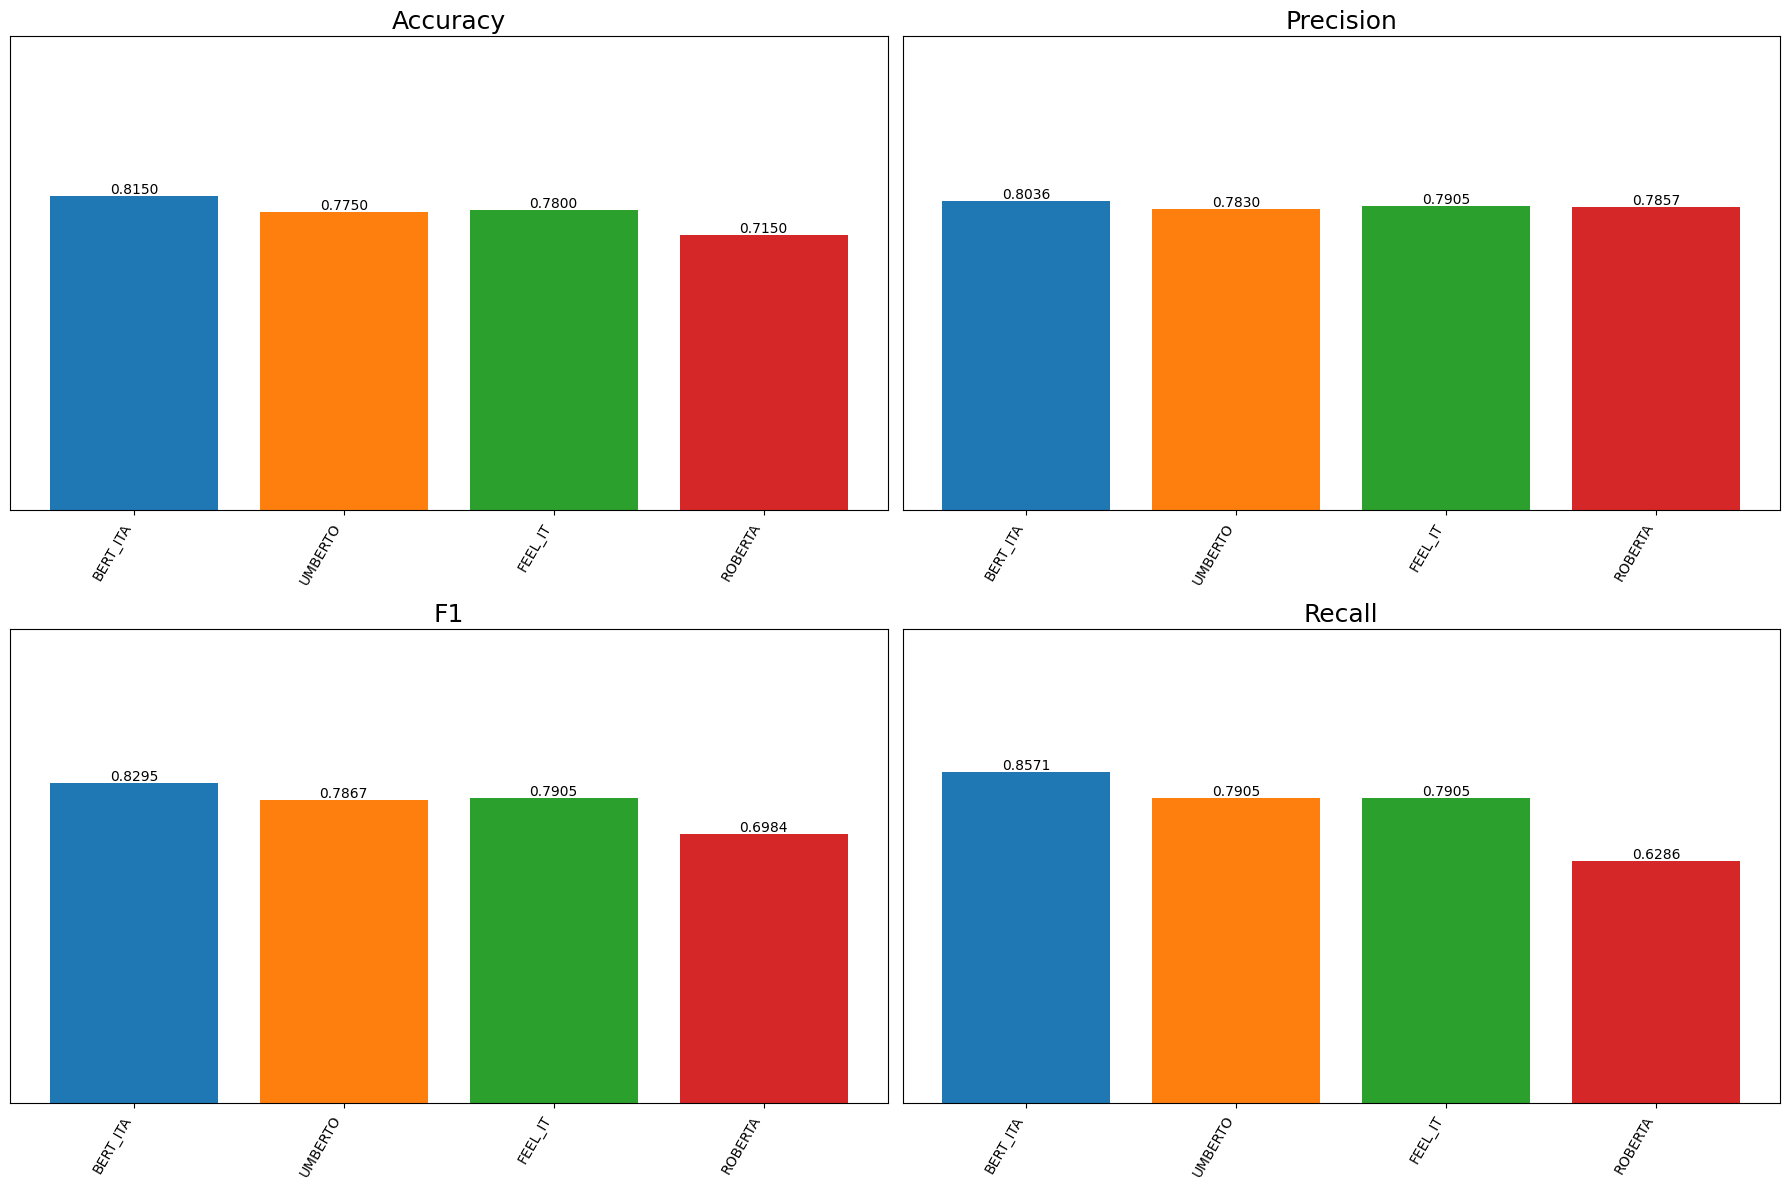

In [88]:
height1 = [metrics5['accuracy'],  metrics6['accuracy'],  metrics7['accuracy'],  metrics8['accuracy']]
height2 = [metrics5['precision'], metrics6['precision'], metrics7['precision'], metrics8['precision']]
height3 = [metrics5['f1'],        metrics6['f1'],        metrics7['f1'],        metrics8['f1']]
height4 = [metrics5['recall'],    metrics6['recall'],    metrics7['recall'],    metrics8['recall']]
labels = ['BERT_ITA', 'UMBERTO', 'FEEL_IT', 'ROBERTA']

fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))
colors = mcolors.TABLEAU_COLORS
bars1 = ax1.bar(labels, height=height1, color=colors)
for rect in bars1:
     height = rect.get_height()
     ax1.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.4f}', ha='center', va='bottom')
bars2 = ax2.bar(labels, height=height2, color=colors)
for rect in bars2:
     height = rect.get_height()
     ax2.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.4f}', ha='center', va='bottom')
bars3 = ax3.bar(labels, height=height3, color=colors)
for rect in bars3:
     height = rect.get_height()
     ax3.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.4f}', ha='center', va='bottom')
bars4 = ax4.bar(labels, height=height4, color=colors)
for rect in bars4:
     height = rect.get_height()
     ax4.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.4f}', ha='center', va='bottom')

ax1.set_yticks([])
ax2.set_yticks([])
ax3.set_yticks([])
ax4.set_yticks([])
ax1.set_title('Accuracy', fontsize = 18)
ax2.set_title('Precision', fontsize = 18)
ax3.set_title('F1', fontsize = 18)
ax4.set_title('Recall', fontsize = 18)
ax1.set_ylim(ymin=0, ymax=(max(height3)+.4))
ax2.set_ylim(ymin=0, ymax=(max(height3)+.4))
ax3.set_ylim(ymin=0, ymax=(max(height3)+.4))
ax4.set_ylim(ymin=0, ymax=(max(height3)+.4))
ax1.set_xticklabels(labels, rotation = 60, ha="right")
ax2.set_xticklabels(labels, rotation = 60, ha="right")
ax3.set_xticklabels(labels, rotation = 60, ha="right")
ax4.set_xticklabels(labels, rotation = 60, ha="right")
plt.tight_layout()
plt.show()

In [101]:
print(''.join(['> ' for i in range(50)]))
print(f'\n{"MODEL":<15}{"BASIC":>22}{"PLUS":>22}{"GAIN":>22}\n')
print(''.join(['> ' for i in range(50)]))
bert_basic = np.mean([i for i in metrics1.values()])
bert_plus = np.mean([i for i in metrics5.values()])
umberto_basic = np.mean([i for i in metrics2.values()])
umberto_plus = np.mean([i for i in metrics6.values()])
feelit_basic = np.mean([i for i in metrics3.values()])
feelit_plus = np.mean([i for i in metrics7.values()])
roberta_basic = np.mean([i for i in metrics4.values()])
roberta_plus = np.mean([i for i in metrics8.values()])
print(f'\033[1m{"BERT_ITA:":<15}{bert_basic:>22.3f}{bert_plus:>22.3f}{bert_plus-bert_basic:>22.3f}\033[0m')
print(f'{"UMBERTO:":<15}{umberto_basic:>22.3f}{umberto_plus:>22.3f}{umberto_plus-umberto_basic:>22.3f}')
print(f'{"FEEL_IT:":<15}{feelit_basic:>22.3f}{feelit_plus:>22.3f}{feelit_plus-feelit_basic:>22.3f}')
print(f'{"ROBERTA:":<15}{roberta_basic:>22.3f}{roberta_plus:>22.3f}{roberta_plus-roberta_basic:>22.3f}')

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

MODEL                           BASIC                  PLUS                  GAIN

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 
BERT_ITA:                       0.807                 0.826                 0.020
UMBERTO:                        0.749                 0.784                 0.035
FEEL_IT:                        0.818                 0.788                -0.030
ROBERTA:                        0.803                 0.707                -0.096


## 2\) Multimodal classification

In [98]:
def get_majority_vote(list_pred):
    major_pred = []
    for i in range(len(list_pred[0])):
        col = np.array(list_pred)
        major_pred.append(np.bincount(col[:,i]).argmax())
    return major_pred

In [120]:
### GETTING PREDICTIONS FROM TEXTUAL FEATURES
pt_save_directory = './saved_models/feel_it'
tokenizer = AutoTokenizer.from_pretrained(pt_save_directory, model_max_length=512)
tokenized_datasets = myCustomDataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(['File', 'Engagement', 'Manipulation', 'Visual', 'Text'])
tokenized_datasets = tokenized_datasets.rename_column('Hate Speech', 'labels')
tokenized_datasets.set_format("torch")
test_dataloader = DataLoader(tokenized_datasets['test'])
saved_model = AutoModelForSequenceClassification.from_pretrained(pt_save_directory).to(device)
pred1, _ = testing_network(saved_model, test_dataloader)

Loading cached processed dataset at /Users/albertogvalerio/.cache/huggingface/datasets/csv/default-b4b0aa8d7fa28b57/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d/cache-25e53232eae8faca.arrow
Loading cached processed dataset at /Users/albertogvalerio/.cache/huggingface/datasets/csv/default-b4b0aa8d7fa28b57/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d/cache-31aba16a927d61cf.arrow
Loading cached processed dataset at /Users/albertogvalerio/.cache/huggingface/datasets/csv/default-27d1b7e2c5d74982/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d/cache-a825d56499e5e819.arrow


In [100]:
### GETTING PREDICTIONS FROM IMAGES FEATURES
n_features = len(embeddings_train['Train Embeddings'][0])
X_train_net = np.array([i for i in embeddings_train['Train Embeddings'].values])
y_train_net = embeddings_train['Labels'].to_numpy()
X_test_net = np.array([i for i in embeddings_test['Test Embeddings'].values])
y_test_net = embeddings_test['Labels'].to_numpy()
split = int(len(X_train_net) * .8)
X_eval_net = X_train_net[split:]
y_eval_net = y_train_net[split:]
X_train_net = X_train_net[:split]
y_train_net = y_train_net[:split]

X_train_net = torch.tensor(data = X_train_net.reshape(len(X_train_net), n_features), dtype=torch.float32).to(device)
X_eval_net = torch.tensor(data = X_eval_net.reshape(len(X_eval_net), n_features), dtype=torch.float32).to(device)
X_test_net = torch.tensor(data = X_test_net.reshape(len(X_test_net), n_features), dtype=torch.float32).to(device)
y_train_net = torch.tensor(data = y_train_net, dtype=torch.float32).to(device)
y_eval_net = torch.tensor(data = y_eval_net, dtype=torch.float32).to(device)
y_test_net = torch.tensor(data = y_test_net, dtype=torch.float32).to(device)

net = MySimpleNetworkClassifier(n_features).to(device)
model, _ = fit_NN(net, X_train_net, X_eval_net, y_train_net, y_eval_net, n_epochs=6, batch=10, verbose=(False,1))
_, pred2 = predict_NN(model, X_test_net, y_test_net)

In [101]:
### GETTING PREDICTIONS FROM METADATA FEATURES
n_features = 5
X_train_net = metadata_train[['Engagement', 'Manipulation', 'Hate Score', 'Nr Words', 'Nr Tokens']].to_numpy()
y_train_net = metadata_train['Hate Speech'].to_numpy()
X_test_net = metadata_test[['Engagement', 'Manipulation', 'Hate Score', 'Nr Words', 'Nr Tokens']].to_numpy()
y_test_net = metadata_test['Hate Speech'].to_numpy()
split = int(len(X_train_net) * .8)
X_eval_net = X_train_net[split:]
y_eval_net = y_train_net[split:]
X_train_net = X_train_net[:split]
y_train_net = y_train_net[:split]

X_train_net = torch.tensor(data = X_train_net.reshape(len(X_train_net), n_features), dtype=torch.float32).to(device)
X_eval_net = torch.tensor(data = X_eval_net.reshape(len(X_eval_net), n_features), dtype=torch.float32).to(device)
X_test_net = torch.tensor(data = X_test_net.reshape(len(X_test_net), n_features), dtype=torch.float32).to(device)
y_train_net = torch.tensor(data = y_train_net, dtype=torch.float32).to(device)
y_eval_net = torch.tensor(data = y_eval_net, dtype=torch.float32).to(device)
y_test_net = torch.tensor(data = y_test_net, dtype=torch.float32).to(device)

net = MySimpleNetworkClassifier(n_features).to(device)
model, _ = fit_NN(net, X_train_net, X_eval_net, y_train_net, y_eval_net, n_epochs=100, batch=20, verbose=(False,10))
_, pred3 = predict_NN(model, X_test_net, y_test_net)

In [121]:
pred_text = [i[0] for i in pred1]
pred_img = [int(i) for i in pred2.detach().cpu().numpy()]
pred_meta = [int(i) for i in pred3.detach().cpu().numpy()]
ground_truth = [int(i) for i in y_test_net.detach().cpu().numpy()]

final_pred = get_majority_vote([pred_text, pred_img, pred_meta])

print(''.join(['> ' for i in range(50)]))
print(f'\n{"METRIC":<10}{"TEXT":>15}{"IMAGES":>15}{"METADATA":>15}{"MULTIMODAL":>15}\033[1m{"BASELINE":>15}\033[0m{"BEST TEAM":>15}\n')
print(''.join(['> ' for i in range(50)]))
print(f'{"PRECISION:":<10}\033[32m\033[1m{precision_score(ground_truth, pred_text):>15.3f}\033[30m\033[0m{precision_score(ground_truth, pred_img):>15.3f}\033[91m\033[1m{precision_score(ground_truth, pred_meta):>15.3f}\033[0m{precision_score(ground_truth, final_pred):>15.3f}\033[1m{"0.895":>15}\033[0m{"(UPB) 0.833":>15}')
print(f'{"RECALL:":<10}{recall_score(ground_truth, pred_text):>15.3f}\033[91m\033[1m{recall_score(ground_truth, pred_img):>15.3f}\033[0m\033[32m\033[1m{recall_score(ground_truth, pred_meta):>15.3f}\033[30m\033[0m{recall_score(ground_truth, final_pred):>15.3f}\033[1m{"0.409":>15}\033[0m{"(UTor) 0.885":>15}')
print(f'{"F1:":<10}\033[32m\033[1m{f1_score(ground_truth, pred_text):>15.3f}\033[30m\033[0m\033[91m\033[1m{f1_score(ground_truth, pred_img):>15.3f}\033[0m{f1_score(ground_truth, pred_meta):>15.3f}{f1_score(ground_truth, final_pred):>15.3f}\033[1m{"0.562":>15}\033[0m{"(UTor) 0.823":>15}')
print(f'{"ACCURACY:":<10}\033[32m\033[1m{accuracy_score(ground_truth, pred_text):>15.3f}\033[30m\033[0m\033[91m\033[1m{accuracy_score(ground_truth, pred_img):>15.3f}\033[0m{accuracy_score(ground_truth, pred_meta):>15.3f}{accuracy_score(ground_truth, final_pred):>15.3f}\033[1m{"---":>15}\033[0m{"---":>15}')

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

METRIC               TEXT         IMAGES       METADATA     MULTIMODAL       BASELINE      BEST TEAM

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 
PRECISION:          0.897          0.634          0.606          0.854          0.895    (UPB) 0.833
RECALL:             0.743          0.248          0.790          0.667          0.409   (UTor) 0.885
F1:                 0.812          0.356          0.686          0.749          0.562   (UTor) 0.823
ACCURACY:           0.820          0.530          0.620          0.765            ---            ---
